In [1]:
%%capture
!pip install pydub
!pip install noisereduce

In [2]:
%%capture
import os
import numpy as np

from pydub import AudioSegment, effects
import librosa
import librosa.display
import noisereduce as nr

import matplotlib.pyplot as plt
from librosa import display   
import IPython.display as ipd 

from transformers import Wav2Vec2Processor, Wav2Vec2Model
import torch

C:\Users\chenz\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,
C:\Users\chenz\AppData\Local\Temp\ipykernel_21676\1820439682.py:10: FutureWarning: waveshow() keyword argument 'x_axis' has been renamed to 'axis' in version 0.10.0.
	This alias will be removed in version 1.0.
  librosa.display.waveshow(y=y, sr=sr, x_axis='time')


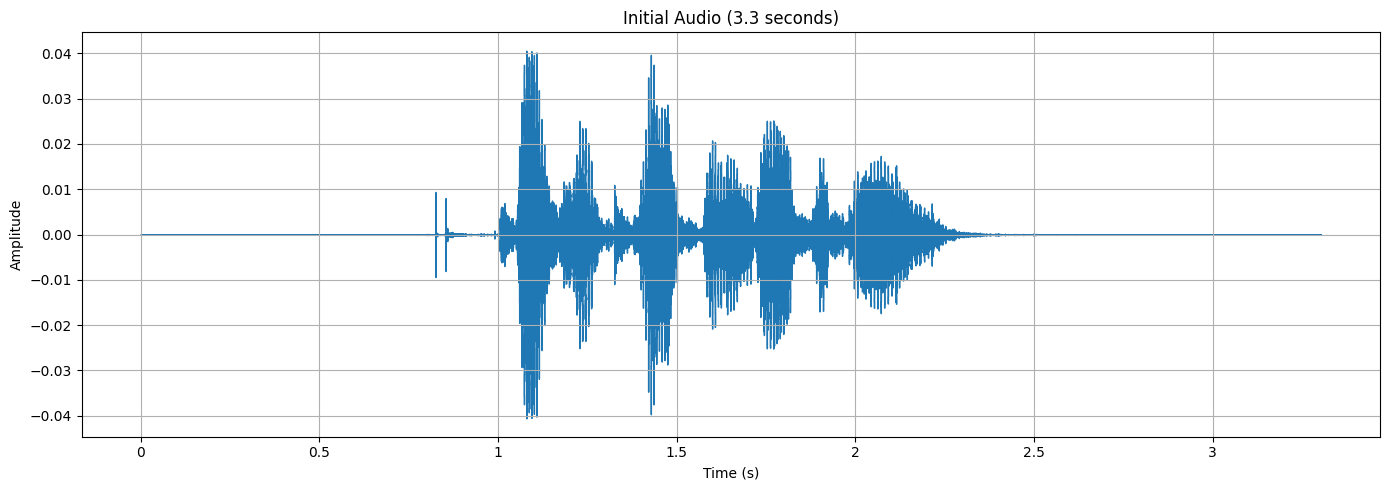

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import librosa
import librosa.display

path = r"C:\Users\chenz\Downloads\RAVDESS\audio_speech_actors_01-24\Actor_01\03-01-01-01-01-01-01.wav"
y, sr = librosa.load(path, sr=None)

plt.figure(figsize=(14, 5))
librosa.display.waveshow(y=y, sr=sr, x_axis='time')
plt.title('Initial Audio (3.3 seconds)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\chenz\AppData\Local\Temp\ipykernel_25640\1124900046.py:28: FutureWarning: waveshow() keyword argument 'x_axis' has been renamed to 'axis' in version 0.10.0.
	This alias will be removed in version 1.0.
  librosa.display.waveshow(y=normal_x, sr=sr_pydub, x_axis='time')


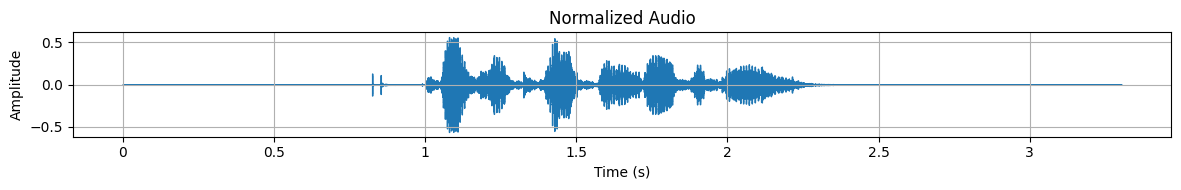

In [8]:
# 2. Normalize to +5.0 dBFS, Transform audio signals to an array.

rawsound = AudioSegment.from_file(path)

# Normalize the audio. `headroom = 5.0` means the peak will be at -5.0 dBFS.
normalizedsound = effects.normalize(rawsound, headroom=5.0)

# Get the sampling rate from the pydub AudioSegment
sr_pydub = normalizedsound.frame_rate

# Transform audio signals to a NumPy array of float32.
# Samples from pydub are integers, so they need to be scaled to -1.0 to 1.0 range
# for proper display and processing with librosa.
normal_x = np.array(normalizedsound.get_array_of_samples(), dtype='float32')

# Scale the samples to the standard -1.0 to 1.0 range for audio processing
# The max_possible_amplitude depends on the bit depth of the audio.
max_amplitude = normalizedsound.max_possible_amplitude
if max_amplitude > 0: # Avoid division by zero if for some reason amplitude is 0
    normal_x = normal_x / max_amplitude
else:
    print("Warning: Audio has no discernible amplitude. Normalization might not be effective.")


# Create the waveplot for the normalized audio
plt.figure(figsize=(12, 2))
# Using waveshow as waveplot is deprecated in newer librosa versions, so we use waveshow.
librosa.display.waveshow(y=normal_x, sr=sr_pydub, x_axis='time')
plt.title('Normalized Audio')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.tight_layout() # Adjusts plot to prevent labels from overlapping
plt.show()



--- Silence Trimming and Plotting ---
Original audio length: 158558 samples
Trimmed audio length: 68608 samples
Silence trimmed: 89950 samples
Trimmed from index 40448 to 109056 (original samples)


C:\Users\chenz\AppData\Local\Temp\ipykernel_25640\3313941741.py:21: FutureWarning: waveshow() keyword argument 'x_axis' has been renamed to 'axis' in version 0.10.0.
	This alias will be removed in version 1.0.
  librosa.display.waveshow(y=xt, sr=sr, x_axis='time')


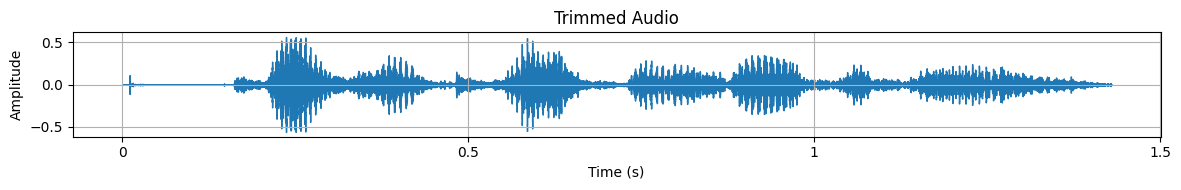


Playing trimmed audio:


In [9]:
# 3. Trim silence in the beginning and end.

sr = sr_pydub

print(f"\n--- Silence Trimming and Plotting ---")

# 1. Trim silence from the beginning and end of the normalized audio.
# 'top_db' is the threshold (in dB) below which audio is considered silence.
# Any audio below 30 dB relative to the peak will be considered silence and trimmed.
# 'index' returns the start and end sample indices of the non-silent part.
xt, index = librosa.effects.trim(normal_x, top_db=30)

print(f"Original audio length: {len(normal_x)} samples")
print(f"Trimmed audio length: {len(xt)} samples")
print(f"Silence trimmed: {len(normal_x) - len(xt)} samples")
print(f"Trimmed from index {index[0]} to {index[1]} (original samples)")

# 2. Create the waveplot for the trimmed audio.
plt.figure(figsize=(12, 2))
# Using waveshow as waveplot is deprecated in newer librosa versions.
librosa.display.waveshow(y=xt, sr=sr, x_axis='time')
plt.title('Trimmed Audio')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.tight_layout() # Adjusts plot to prevent labels from overlapping
plt.show()

# 3. Display an interactive audio player for the trimmed sound.
# This is excellent for quickly listening to the result.
print("\nPlaying trimmed audio:")
ipd.display(ipd.Audio(data=xt, rate=sr))


--- Right-Side Padding and Plotting ---
Current trimmed audio length: 68608 samples
Target padded length: 228864 samples
Padded with 160256 zeros on the right side.
Final padded audio length: 228864 samples


C:\Users\chenz\AppData\Local\Temp\ipykernel_25640\843193180.py:29: FutureWarning: waveshow() keyword argument 'x_axis' has been renamed to 'axis' in version 0.10.0.
	This alias will be removed in version 1.0.
  librosa.display.waveshow(y=padded_x, sr=sr, x_axis='time')


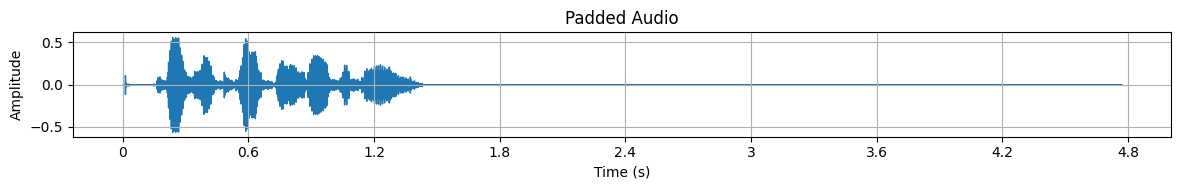


Playing padded audio:


In [10]:
# 4. Right-side padding for length equalization.
#    173056 = maximum lengthed audio 

TARGET_LENGTH = 228864

print(f"\n--- Right-Side Padding and Plotting ---")
print(f"Current trimmed audio length: {len(xt)} samples")
print(f"Target padded length: {TARGET_LENGTH} samples")

# 1. Right-side padding for length equalization.
# np.pad adds zeros to the array.
# (0, TARGET_LENGTH - len(xt)) means 0 padding at the beginning,
# and (TARGET_LENGTH - len(xt)) padding at the end (right side).
# 'constant' padding mode fills with a constant value (default is 0).
if len(xt) < TARGET_LENGTH:
    padded_x = np.pad(xt, (0, TARGET_LENGTH - len(xt)), 'constant')
    print(f"Padded with {TARGET_LENGTH - len(xt)} zeros on the right side.")
else:
    # If the audio is already longer than the target, it will be truncated.
    padded_x = xt[:TARGET_LENGTH]
    print(f"Audio is longer than or equal to the target length. Truncated to {TARGET_LENGTH} samples.")


print(f"Final padded audio length: {len(padded_x)} samples")

# 2. Create the waveplot for the padded audio.
plt.figure(figsize=(12, 2))
# Using waveshow as waveplot is deprecated in newer librosa versions.
librosa.display.waveshow(y=padded_x, sr=sr, x_axis='time')
plt.title('Padded Audio')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.tight_layout() # Adjusts plot to prevent labels from overlapping
plt.show()

# 3. Display an interactive audio player for the padded sound.
print("\nPlaying padded audio:")
ipd.display(ipd.Audio(data=padded_x, rate=sr))


--- Noise Reduction and Plotting ---
Noise reduction applied. Final audio length: 228864 samples


C:\Users\chenz\AppData\Local\Temp\ipykernel_25640\97321102.py:15: FutureWarning: waveshow() keyword argument 'x_axis' has been renamed to 'axis' in version 0.10.0.
	This alias will be removed in version 1.0.
  librosa.display.waveshow(y=final_x, sr=sr, x_axis='time')


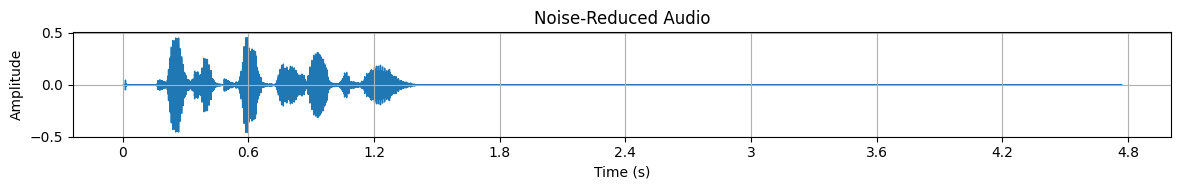


Playing noise-reduced audio:


In [11]:
# 5. Noise reduction

print(f"\n--- Noise Reduction and Plotting ---")

# 1. Perform Noise Reduction
# CORRECTED: Removed 'verbose' argument as it's not accepted by this version.
final_x = nr.reduce_noise(y=padded_x,
                          sr=sr)

print(f"Noise reduction applied. Final audio length: {len(final_x)} samples")

# 2. Create the waveplot for the noise-reduced audio.
plt.figure(figsize=(12, 2))
# Using waveshow as waveplot is deprecated in newer librosa versions.
librosa.display.waveshow(y=final_x, sr=sr, x_axis='time')
plt.title('Noise-Reduced Audio')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.tight_layout() # Adjusts plot to prevent labels from overlapping
plt.show()

# 3. Display an interactive audio player for the noise-reduced sound.
print("\nPlaying noise-reduced audio:")
ipd.display(ipd.Audio(data=final_x, rate=sr))

In [12]:
# --- 1. Load Wav2Vec2 Processor and Model ---
print("Loading Wav2Vec2 Processor and Model...")
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h")
model.eval() # Set the model to evaluation mode

# --- 2. Move Model to GPU if available ---
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
print(f"Model moved to {device} device.")

# --- 3. Prepare Audio Input for Wav2Vec2 ---
TARGET_WAV2VEC2_SR = 16000 # Wav2Vec2 models are typically trained on 16kHz audio

# Resample if the current sampling rate doesn't match Wav2Vec2's expected rate
if sr != TARGET_WAV2VEC2_SR:
    print(f"Resampling audio from {sr} Hz to {TARGET_WAV2VEC2_SR} Hz for Wav2Vec2.")
    # Ensure audio is float32 as librosa.resample expects it
    audio_for_wav2vec2 = librosa.resample(y=final_x.astype(np.float32),
                                          orig_sr=sr,
                                          target_sr=TARGET_WAV2VEC2_SR)
else:
    audio_for_wav2vec2 = final_x.astype(np.float32) # Ensure it's float32

# --- 4. Process Audio and Extract Features ---
print("Processing audio and extracting features...")

# Process the audio with the Wav2Vec2 processor
# This handles tokenization, padding to the longest sequence in a batch,
# and converts to PyTorch tensors.
inputs = processor(audio_for_wav2vec2, sampling_rate=TARGET_WAV2VEC2_SR, return_tensors="pt")

# Move input tensors to the same device as the model (GPU or CPU)
inputs = {name: tensor.to(device) for name, tensor in inputs.items()}

# Extract features (hidden states)
with torch.no_grad(): # Disable gradient calculations for inference, saves memory and speeds up computation
    outputs = model(**inputs)

# The last_hidden_state contains the contextualized embeddings (features)
# Squeeze to remove the batch dimension (if it's a single audio file)
# Move to CPU and convert to NumPy array for easier downstream processing/saving
features = outputs.last_hidden_state.squeeze().cpu().numpy()

print(f"Features extracted successfully!")
print(f"Shape of extracted features: {features.shape}")
print(f"Data type of extracted features: {features.dtype}")
print(f"First 5 feature vectors (rows):")
print(features[:5])


Loading Wav2Vec2 Processor and Model...


C:\Users\chenz\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Model moved to cpu device.
Resampling audio from 48000 Hz to 16000 Hz for Wav2Vec2.
Processing audio and extracting features...
Features extracted successfully!
Shape of extracted features: (238, 768)
Data type of extracted features: float32
First 5 feature vectors (rows):
[[-0.12917839  0.03249047  0.01690941 ...  0.03747712  0.05957947
  -0.01484071]
 [-0.12829278  0.01912175  0.04267812 ...  0.03513122  0.04585684
  -0.0273541 ]
 [-0.1289009   0.01916361  0.04463138 ...  0.03959482  0.04800711
  -0.02959212]
 [-0.12925261  0.026128    0.03684066 ...  0.0439893   0.05705351
  -0.02095245]
 [-0.13037626  0.02979567  0.0303163  ...  0.04219443  0.05925808
  -0.01483789]]


## There is a different representation of the emotions in each database.

## RAVDESS Database
A RAVDESS filename consists of a 7-part numerical identifier (e.g., 03-01-06-01-02-01-12.wav). The format which carries only emotion expressed by speech is taken as 03-01-X-X-X-X-X.wav, as the 8 emotions are stated in the 3rd part (The 1st 'X' within the file-name format).

## TESS Database
A TESS file name contains the emotion by a direct text, e.g. "YAF_youth_happy.wav".

To overcome this incompatibility with the RAVDESS representation, "find_emotion" function has been executed.

In addition, classification modeling accepting only values starting from zero, thus "emotionfix" function has been executed for all files, performing an 'n = n-1' process for the emotion representation.

In [13]:
# Emotion kind validation function for TESS database, due to emotions written within the file names.
def find_emotion_T(name): 
        if('neutral' in name): return "01"
        elif('happy' in name): return "03"
        elif('sad' in name): return "04"
        elif('angry' in name): return "05"
        elif('fear' in name): return "06"
        elif('disgust' in name): return "07"
        elif('ps' in name): return "08"
        else: return "-1"
        
        
# 'emotions' list fix for classification purposes:
#     Classification values start from 0, Thus an 'n = n-1' operation has been executed for both RAVDESS and TESS databases:
def emotionfix(e_num):
    if e_num == "01":   return 0 # neutral
    elif e_num == "02": return 1 # calm
    elif e_num == "03": return 2 # happy
    elif e_num == "04": return 3 # sad
    elif e_num == "05": return 4 # angry
    elif e_num == "06": return 5 # fear
    elif e_num == "07": return 6 # disgust
    else:               return 7 # suprised

In [14]:
import os
import numpy as np
import librosa
from pydub import AudioSegment, effects
from pydub.utils import which

# Ensure FFmpeg is available to pydub
AudioSegment.converter = which("C:\\ffmpeg\\bin\\ffmpeg.exe")  # Adjust this path if needed

# Folder containing audio files
folder_path = r"C:\Users\chenz\Documents\AudioFiles"

# Pre-processing parameters
NORMALIZATION_HEADROOM_DBFS = 5.0
TRIM_TOP_DB = 30  # Silence threshold for librosa.effects.trim

# Store trimmed sample lengths
sample_lengths = []

print(f"Starting to scan audio files in: {folder_path}")

# Walk through all .wav files
for subdir, dirs, files in os.walk(folder_path):
    for file in files:
        if file.lower().endswith(".wav"):
            audio_file_path = os.path.join(subdir, file)
            print(f"Processing file: {audio_file_path}")

            try:
                # Load and normalize
                rawsound = AudioSegment.from_file(audio_file_path)
                normalizedsound = effects.normalize(rawsound, headroom=NORMALIZATION_HEADROOM_DBFS)

                # Convert to float32 array and scale to [-1, 1]
                normal_x = np.array(normalizedsound.get_array_of_samples(), dtype='float32')
                max_amplitude = normalizedsound.max_possible_amplitude
                if max_amplitude > 0:
                    normal_x = normal_x / max_amplitude
                else:
                    normal_x = np.array([0.0], dtype='float32')  # Treat silent audio as zero

                # Trim silence
                xt, _ = librosa.effects.trim(normal_x, top_db=TRIM_TOP_DB)
                sample_lengths.append(len(xt))

            except Exception as e:
                print(f"Error processing {audio_file_path}: {e}")

# Final output
if sample_lengths:
    max_sample_length = np.max(sample_lengths)
    print(f"\nMaximum trimmed sample length found: {max_sample_length}")
else:
    print("\nNo valid WAV files found or processed.")


Starting to scan audio files in: C:\Users\chenz\Documents\AudioFiles
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_01\03-01-01-01-01-01-01.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_01\03-01-01-01-01-02-01.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_01\03-01-01-01-02-01-01.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_01\03-01-01-01-02-02-01.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_01\03-01-02-01-01-01-01.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_01\03-01-02-01-01-02-01.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_01\03-01-02-01-02-01-01.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_01\03-01-02-01-02-02-01.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_01\03-01-02-02-01-01-01.wav
Proc

Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_02\03-01-06-02-02-01-02.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_02\03-01-06-02-02-02-02.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_02\03-01-07-01-01-01-02.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_02\03-01-07-01-01-02-02.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_02\03-01-07-01-02-01-02.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_02\03-01-07-01-02-02-02.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_02\03-01-07-02-01-01-02.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_02\03-01-07-02-01-02-02.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_02\03-01-07-02-02-01-02.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Acto

Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_04\03-01-04-01-01-02-04.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_04\03-01-04-01-02-01-04.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_04\03-01-04-01-02-02-04.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_04\03-01-04-02-01-01-04.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_04\03-01-04-02-01-02-04.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_04\03-01-04-02-02-01-04.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_04\03-01-04-02-02-02-04.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_04\03-01-05-01-01-01-04.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_04\03-01-05-01-01-02-04.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Acto

Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_06\03-01-01-01-01-02-06.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_06\03-01-01-01-02-01-06.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_06\03-01-01-01-02-02-06.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_06\03-01-02-01-01-01-06.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_06\03-01-02-01-01-02-06.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_06\03-01-02-01-02-01-06.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_06\03-01-02-01-02-02-06.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_06\03-01-02-02-01-01-06.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_06\03-01-02-02-01-02-06.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Acto

Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_07\03-01-07-01-02-01-07.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_07\03-01-07-01-02-02-07.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_07\03-01-07-02-01-01-07.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_07\03-01-07-02-01-02-07.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_07\03-01-07-02-02-01-07.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_07\03-01-07-02-02-02-07.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_07\03-01-08-01-01-01-07.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_07\03-01-08-01-01-02-07.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_07\03-01-08-01-02-01-07.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Acto

Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_09\03-01-05-01-02-01-09.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_09\03-01-05-01-02-02-09.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_09\03-01-05-02-01-01-09.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_09\03-01-05-02-01-02-09.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_09\03-01-05-02-02-01-09.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_09\03-01-05-02-02-02-09.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_09\03-01-06-01-01-01-09.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_09\03-01-06-01-01-02-09.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_09\03-01-06-01-02-01-09.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Acto

Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_11\03-01-03-01-02-01-11.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_11\03-01-03-01-02-02-11.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_11\03-01-03-02-01-01-11.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_11\03-01-03-02-01-02-11.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_11\03-01-03-02-02-01-11.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_11\03-01-03-02-02-02-11.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_11\03-01-04-01-01-01-11.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_11\03-01-04-01-01-02-11.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_11\03-01-04-01-02-01-11.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Acto

Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_12\03-01-07-02-02-01-12.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_12\03-01-07-02-02-02-12.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_12\03-01-08-01-01-01-12.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_12\03-01-08-01-01-02-12.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_12\03-01-08-01-02-01-12.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_12\03-01-08-01-02-02-12.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_12\03-01-08-02-01-01-12.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_12\03-01-08-02-01-02-12.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_12\03-01-08-02-02-01-12.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Acto

Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_14\03-01-06-02-02-01-14.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_14\03-01-06-02-02-02-14.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_14\03-01-07-01-01-01-14.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_14\03-01-07-01-01-02-14.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_14\03-01-07-01-02-01-14.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_14\03-01-07-01-02-02-14.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_14\03-01-07-02-01-01-14.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_14\03-01-07-02-01-02-14.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_14\03-01-07-02-02-01-14.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Acto

Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_16\03-01-05-01-02-01-16.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_16\03-01-05-01-02-02-16.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_16\03-01-05-02-01-01-16.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_16\03-01-05-02-01-02-16.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_16\03-01-05-02-02-01-16.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_16\03-01-05-02-02-02-16.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_16\03-01-06-01-01-01-16.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_16\03-01-06-01-01-02-16.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_16\03-01-06-01-02-01-16.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Acto

Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_18\03-01-02-02-02-02-18.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_18\03-01-03-01-01-01-18.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_18\03-01-03-01-01-02-18.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_18\03-01-03-01-02-01-18.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_18\03-01-03-01-02-02-18.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_18\03-01-03-02-01-01-18.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_18\03-01-03-02-01-02-18.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_18\03-01-03-02-02-01-18.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_18\03-01-03-02-02-02-18.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Acto

Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_19\03-01-05-02-01-01-19.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_19\03-01-05-02-01-02-19.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_19\03-01-05-02-02-01-19.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_19\03-01-05-02-02-02-19.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_19\03-01-06-01-01-01-19.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_19\03-01-06-01-01-02-19.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_19\03-01-06-01-02-01-19.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_19\03-01-06-01-02-02-19.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_19\03-01-06-02-01-01-19.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Acto

Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_21\03-01-03-01-01-01-21.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_21\03-01-03-01-01-02-21.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_21\03-01-03-01-02-01-21.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_21\03-01-03-01-02-02-21.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_21\03-01-03-02-01-01-21.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_21\03-01-03-02-01-02-21.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_21\03-01-03-02-02-01-21.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_21\03-01-03-02-02-02-21.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_21\03-01-04-01-01-01-21.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Acto

Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_22\03-01-07-02-02-02-22.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_22\03-01-08-01-01-01-22.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_22\03-01-08-01-01-02-22.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_22\03-01-08-01-02-01-22.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_22\03-01-08-01-02-02-22.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_22\03-01-08-02-01-01-22.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_22\03-01-08-02-01-02-22.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_22\03-01-08-02-02-01-22.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_22\03-01-08-02-02-02-22.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Acto

Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_24\03-01-05-01-01-02-24.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_24\03-01-05-01-02-01-24.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_24\03-01-05-01-02-02-24.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_24\03-01-05-02-01-01-24.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_24\03-01-05-02-01-02-24.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_24\03-01-05-02-02-01-24.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_24\03-01-05-02-02-02-24.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_24\03-01-06-01-01-01-24.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Actor_24\03-01-06-01-01-02-24.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\Acto

Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_02\03-01-02-01-02-01-02.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_02\03-01-02-01-02-02-02.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_02\03-01-02-02-01-01-02.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_02\03-01-02-02-01-02-02.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_02\03-01-02-02-02-01-02.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_02\03-01-02-02-02-02-02.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_02\03-01-03-01-01-01-02.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Ac

Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_03\03-01-03-01-02-02-03.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_03\03-01-03-02-01-01-03.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_03\03-01-03-02-01-02-03.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_03\03-01-03-02-02-01-03.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_03\03-01-03-02-02-02-03.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_03\03-01-04-01-01-01-03.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_03\03-01-04-01-01-02-03.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Ac

Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_04\03-01-08-01-01-02-04.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_04\03-01-08-01-02-01-04.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_04\03-01-08-01-02-02-04.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_04\03-01-08-02-01-01-04.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_04\03-01-08-02-01-02-04.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_04\03-01-08-02-02-01-04.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_04\03-01-08-02-02-02-04.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Ac

Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_05\03-01-08-02-02-02-05.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_06\03-01-01-01-01-01-06.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_06\03-01-01-01-01-02-06.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_06\03-01-01-01-02-01-06.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_06\03-01-01-01-02-02-06.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_06\03-01-02-01-01-01-06.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_06\03-01-02-01-01-02-06.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Ac

Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_07\03-01-01-01-02-02-07.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_07\03-01-02-01-01-01-07.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_07\03-01-02-01-01-02-07.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_07\03-01-02-01-02-01-07.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_07\03-01-02-01-02-02-07.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_07\03-01-02-02-01-01-07.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_07\03-01-02-02-01-02-07.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Ac

Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_08\03-01-02-02-02-02-08.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_08\03-01-03-01-01-01-08.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_08\03-01-03-01-01-02-08.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_08\03-01-03-01-02-01-08.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_08\03-01-03-01-02-02-08.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_08\03-01-03-02-01-01-08.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_08\03-01-03-02-01-02-08.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Ac

Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_09\03-01-03-02-02-01-09.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_09\03-01-03-02-02-02-09.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_09\03-01-04-01-01-01-09.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_09\03-01-04-01-01-02-09.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_09\03-01-04-01-02-01-09.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_09\03-01-04-01-02-02-09.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_09\03-01-04-02-01-01-09.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Ac

Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_10\03-01-05-01-01-02-10.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_10\03-01-05-01-02-01-10.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_10\03-01-05-01-02-02-10.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_10\03-01-05-02-01-01-10.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_10\03-01-05-02-01-02-10.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_10\03-01-05-02-02-01-10.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_10\03-01-05-02-02-02-10.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Ac

Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_11\03-01-07-02-01-02-11.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_11\03-01-07-02-02-01-11.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_11\03-01-07-02-02-02-11.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_11\03-01-08-01-01-01-11.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_11\03-01-08-01-01-02-11.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_11\03-01-08-01-02-01-11.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_11\03-01-08-01-02-02-11.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Ac

Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_13\03-01-05-01-02-02-13.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_13\03-01-05-02-01-01-13.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_13\03-01-05-02-01-02-13.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_13\03-01-05-02-02-01-13.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_13\03-01-05-02-02-02-13.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_13\03-01-06-01-01-01-13.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_13\03-01-06-01-01-02-13.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Ac

Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_14\03-01-06-02-02-02-14.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_14\03-01-07-01-01-01-14.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_14\03-01-07-01-01-02-14.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_14\03-01-07-01-02-01-14.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_14\03-01-07-01-02-02-14.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_14\03-01-07-02-01-01-14.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_14\03-01-07-02-01-02-14.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Ac

Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_15\03-01-08-02-02-01-15.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_15\03-01-08-02-02-02-15.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_16\03-01-01-01-01-01-16.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_16\03-01-01-01-01-02-16.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_16\03-01-01-01-02-01-16.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_16\03-01-01-01-02-02-16.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_16\03-01-02-01-01-01-16.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Ac

Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_17\03-01-02-02-01-01-17.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_17\03-01-02-02-01-02-17.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_17\03-01-02-02-02-01-17.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_17\03-01-02-02-02-02-17.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_17\03-01-03-01-01-01-17.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_17\03-01-03-01-01-02-17.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_17\03-01-03-01-02-01-17.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Ac

Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_18\03-01-04-01-01-01-18.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_18\03-01-04-01-01-02-18.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_18\03-01-04-01-02-01-18.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_18\03-01-04-01-02-02-18.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_18\03-01-04-02-01-01-18.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_18\03-01-04-02-01-02-18.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_18\03-01-04-02-02-01-18.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Ac

Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_19\03-01-05-01-01-02-19.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_19\03-01-05-01-02-01-19.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_19\03-01-05-01-02-02-19.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_19\03-01-05-02-01-01-19.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_19\03-01-05-02-01-02-19.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_19\03-01-05-02-02-01-19.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_19\03-01-05-02-02-02-19.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Ac

Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_20\03-01-05-02-02-01-20.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_20\03-01-05-02-02-02-20.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_20\03-01-06-01-01-01-20.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_20\03-01-06-01-01-02-20.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_20\03-01-06-01-02-01-20.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_20\03-01-06-01-02-02-20.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_20\03-01-06-02-01-01-20.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Ac

Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_21\03-01-07-01-02-01-21.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_21\03-01-07-01-02-02-21.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_21\03-01-07-02-01-01-21.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_21\03-01-07-02-01-02-21.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_21\03-01-07-02-02-01-21.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_21\03-01-07-02-02-02-21.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_21\03-01-08-01-01-01-21.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Ac

Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_23\03-01-02-01-01-01-23.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_23\03-01-02-01-01-02-23.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_23\03-01-02-01-02-01-23.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_23\03-01-02-01-02-02-23.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_23\03-01-02-02-01-01-23.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_23\03-01-02-02-01-02-23.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_23\03-01-02-02-02-01-23.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Ac

Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_24\03-01-03-02-01-01-24.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_24\03-01-03-02-01-02-24.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_24\03-01-03-02-02-01-24.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_24\03-01-03-02-02-02-24.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_24\03-01-04-01-01-01-24.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_24\03-01-04-01-01-02-24.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Actor_24\03-01-04-01-02-01-24.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\RAVDESS\RAVDESS\audio_speech_actors_01-24\Ac

Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\OAF_angry\OAF_live_angry.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\OAF_angry\OAF_loaf_angry.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\OAF_angry\OAF_long_angry.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\OAF_angry\OAF_lore_angry.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\OAF_angry\OAF_lose_angry.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\OAF_angry\OAF_lot_angry.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\OAF_angry\OAF_love_angry.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\OAF_angry\OAF_luck_ang

Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\OAF_angry\OAF_yearn_angry.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\OAF_angry\OAF_yes_angry.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\OAF_angry\OAF_young_angry.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\OAF_angry\OAF_youth_angry.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\OAF_disgust\OAF_back_disgust.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\OAF_disgust\OAF_bar_disgust.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\OAF_disgust\OAF_base_disgust.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\OAF_disg

Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\OAF_disgust\OAF_kill_disgust.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\OAF_disgust\OAF_king_disgust.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\OAF_disgust\OAF_kite_disgust.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\OAF_disgust\OAF_knock_disgust.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\OAF_disgust\OAF_late_disgust.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\OAF_disgust\OAF_laud_disgust.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\OAF_disgust\OAF_lean_disgust.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech s

Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\OAF_disgust\OAF_ton_disgust.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\OAF_disgust\OAF_tool_disgust.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\OAF_disgust\OAF_tough_disgust.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\OAF_disgust\OAF_turn_disgust.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\OAF_disgust\OAF_vine_disgust.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\OAF_disgust\OAF_voice_disgust.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\OAF_disgust\OAF_void_disgust.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech s

Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\OAF_Fear\OAF_lose_fear.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\OAF_Fear\OAF_lot_fear.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\OAF_Fear\OAF_love_fear.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\OAF_Fear\OAF_luck_fear.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\OAF_Fear\OAF_make_fear.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\OAF_Fear\OAF_match_fear.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\OAF_Fear\OAF_merge_fear.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\OAF_Fear\OAF_mess_fear.wav
Process

Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\OAF_happy\OAF_bar_happy.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\OAF_happy\OAF_base_happy.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\OAF_happy\OAF_bath_happy.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\OAF_happy\OAF_bean_happy.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\OAF_happy\OAF_beg_happy.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\OAF_happy\OAF_bite_happy.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\OAF_happy\OAF_boat_happy.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\OAF_happy\OAF_bone_happ

Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\OAF_happy\OAF_met_happy.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\OAF_happy\OAF_mill_happy.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\OAF_happy\OAF_mob_happy.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\OAF_happy\OAF_mode_happy.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\OAF_happy\OAF_mood_happy.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\OAF_happy\OAF_moon_happy.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\OAF_happy\OAF_mop_happy.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\OAF_happy\OAF_mouse_happ

Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\OAF_happy\OAF_yearn_happy.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\OAF_happy\OAF_yes_happy.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\OAF_happy\OAF_young_happy.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\OAF_happy\OAF_youth_happy.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\OAF_neutral\OAF_back_neutral.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\OAF_neutral\OAF_bar_neutral.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\OAF_neutral\OAF_base_neutral.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\OAF_neut

Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\OAF_neutral\OAF_lore_neutral.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\OAF_neutral\OAF_lose_neutral.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\OAF_neutral\OAF_lot_neutral.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\OAF_neutral\OAF_love_neutral.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\OAF_neutral\OAF_luck_neutral.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\OAF_neutral\OAF_make_neutral.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\OAF_neutral\OAF_match_neutral.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech se

Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\OAF_neutral\OAF_vine_neutral.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\OAF_neutral\OAF_voice_neutral.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\OAF_neutral\OAF_void_neutral.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\OAF_neutral\OAF_vote_neutral.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\OAF_neutral\OAF_wag_neutral.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\OAF_neutral\OAF_walk_neutral.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\OAF_neutral\OAF_wash_neutral.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech se

Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\OAF_Pleasant_surprise\OAF_kill_ps.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\OAF_Pleasant_surprise\OAF_king_ps.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\OAF_Pleasant_surprise\OAF_kite_ps.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\OAF_Pleasant_surprise\OAF_knock_ps.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\OAF_Pleasant_surprise\OAF_late_ps.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\OAF_Pleasant_surprise\OAF_laud_ps.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\OAF_Pleasant_surprise\OAF_lean_ps.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\T

Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\OAF_Pleasant_surprise\OAF_thought_ps.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\OAF_Pleasant_surprise\OAF_thumb_ps.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\OAF_Pleasant_surprise\OAF_time_ps.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\OAF_Pleasant_surprise\OAF_tip_ps.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\OAF_Pleasant_surprise\OAF_tire_ps.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\OAF_Pleasant_surprise\OAF_ton_ps.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\OAF_Pleasant_surprise\OAF_tool_ps.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\

Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\OAF_Sad\OAF_gun_sad.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\OAF_Sad\OAF_half_sad.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\OAF_Sad\OAF_hall_sad.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\OAF_Sad\OAF_hash_sad.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\OAF_Sad\OAF_hate_sad.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\OAF_Sad\OAF_have_sad.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\OAF_Sad\OAF_haze_sad.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\OAF_Sad\OAF_hire_sad.wav
Processing file: C:\Users

Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\OAF_Sad\OAF_search_sad.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\OAF_Sad\OAF_seize_sad.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\OAF_Sad\OAF_sell_sad.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\OAF_Sad\OAF_shack_sad.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\OAF_Sad\OAF_shall_sad.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\OAF_Sad\OAF_shawl_sad.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\OAF_Sad\OAF_sheep_sad.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\OAF_Sad\OAF_shirt_sad.wav
Processing file:

Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\YAF_angry\YAF_date_angry.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\YAF_angry\YAF_dead_angry.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\YAF_angry\YAF_death_angry.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\YAF_angry\YAF_deep_angry.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\YAF_angry\YAF_dime_angry.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\YAF_angry\YAF_dip_angry.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\YAF_angry\YAF_ditch_angry.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\YAF_angry\YAF_dodge_

C:\Users\chenz\anaconda3\Lib\site-packages\pydub\utils.py:198: RuntimeWarning: Couldn't find ffprobe or avprobe - defaulting to ffprobe, but may not work
  warn("Couldn't find ffprobe or avprobe - defaulting to ffprobe, but may not work", RuntimeWarning)


Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\YAF_angry\YAF_nag_angry.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\YAF_angry\YAF_name_angry.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\YAF_angry\YAF_near_angry.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\YAF_angry\YAF_neat_angry.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\YAF_angry\YAF_nice_angry.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\YAF_angry\YAF_note_angry.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\YAF_angry\YAF_numb_angry.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\YAF_angry\YAF_pad_angr

Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\YAF_disgust\YAF_bone_disgust.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\YAF_disgust\YAF_book_disgust.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\YAF_disgust\YAF_bought_disgust.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\YAF_disgust\YAF_burn_disgust.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\YAF_disgust\YAF_cab_disgust.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\YAF_disgust\YAF_calm_disgust.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\YAF_disgust\YAF_came_disgust.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech s

Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\YAF_disgust\YAF_lose_disgust.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\YAF_disgust\YAF_lot_disgust.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\YAF_disgust\YAF_love_disgust.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\YAF_disgust\YAF_luck_disgust.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\YAF_disgust\YAF_make_disgust.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\YAF_disgust\YAF_match_disgust.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\YAF_disgust\YAF_merge_disgust.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech s

Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\YAF_disgust\YAF_walk_disgust.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\YAF_disgust\YAF_wash_disgust.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\YAF_disgust\YAF_week_disgust.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\YAF_disgust\YAF_wheat_disgust.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\YAF_disgust\YAF_when_disgust.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\YAF_disgust\YAF_which_disgust.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\YAF_disgust\YAF_whip_disgust.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech 

Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\YAF_fear\YAF_mood_fear.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\YAF_fear\YAF_moon_fear.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\YAF_fear\YAF_mop_fear.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\YAF_fear\YAF_mouse_fear.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\YAF_fear\YAF_nag_fear.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\YAF_fear\YAF_name_fear.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\YAF_fear\YAF_near_fear.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\YAF_fear\YAF_neat_fear.wav
Error pro

Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\YAF_happy\YAF_bite_happy.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\YAF_happy\YAF_boat_happy.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\YAF_happy\YAF_bone_happy.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\YAF_happy\YAF_book_happy.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\YAF_happy\YAF_bought_happy.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\YAF_happy\YAF_burn_happy.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\YAF_happy\YAF_cab_happy.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\YAF_happy\YAF_calm_h

Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\YAF_happy\YAF_nag_happy.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\YAF_happy\YAF_name_happy.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\YAF_happy\YAF_near_happy.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\YAF_happy\YAF_neat_happy.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\YAF_happy\YAF_nice_happy.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\YAF_happy\YAF_note_happy.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\YAF_happy\YAF_numb_happy.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\YAF_happy\YAF_pad_happ

Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\YAF_neutral\YAF_book_neutral.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\YAF_neutral\YAF_bought_neutral.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\YAF_neutral\YAF_burn_neutral.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\YAF_neutral\YAF_cab_neutral.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\YAF_neutral\YAF_calm_neutral.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\YAF_neutral\YAF_came_neutral.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\YAF_neutral\YAF_cause_neutral.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech 

Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\YAF_neutral\YAF_near_neutral.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\YAF_neutral\YAF_neat_neutral.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\YAF_neutral\YAF_nice_neutral.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\YAF_neutral\YAF_note_neutral.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\YAF_neutral\YAF_numb_neutral.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\YAF_neutral\YAF_pad_neutral.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\YAF_neutral\YAF_page_neutral.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set

Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\YAF_pleasant_surprised\YAF_base_ps.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\YAF_pleasant_surprised\YAF_bath_ps.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\YAF_pleasant_surprised\YAF_bean_ps.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\YAF_pleasant_surprised\YAF_beg_ps.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\YAF_pleasant_surprised\YAF_bite_ps.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\YAF_pleasant_surprised\YAF_boat_ps.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\YAF_pleasant_surprised\YAF_bone_ps.wav
Processing file: C:\Users\chenz\Documents\AudioFi

Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\YAF_pleasant_surprised\YAF_match_ps.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\YAF_pleasant_surprised\YAF_merge_ps.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\YAF_pleasant_surprised\YAF_mess_ps.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\YAF_pleasant_surprised\YAF_met_ps.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\YAF_pleasant_surprised\YAF_mill_ps.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\YAF_pleasant_surprised\YAF_mob_ps.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\YAF_pleasant_surprised\YAF_mode_ps.wav
Processing file: C:\Users\chenz\Documents\AudioF

Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\YAF_pleasant_surprised\YAF_youth_ps.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\YAF_sad\YAF_back_sad.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\YAF_sad\YAF_bar_sad.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\YAF_sad\YAF_base_sad.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\YAF_sad\YAF_bath_sad.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\YAF_sad\YAF_bean_sad.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\YAF_sad\YAF_beg_sad.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\YAF_sad\YAF_bite_sad.wav
Processing 

Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\YAF_sad\YAF_long_sad.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\YAF_sad\YAF_lore_sad.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\YAF_sad\YAF_lose_sad.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\YAF_sad\YAF_lot_sad.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\YAF_sad\YAF_love_sad.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\YAF_sad\YAF_luck_sad.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\YAF_sad\YAF_make_sad.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\YAF_sad\YAF_match_sad.wav
Processing file: C:\User

Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\YAF_sad\YAF_which_sad.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\YAF_sad\YAF_whip_sad.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\YAF_sad\YAF_white_sad.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\YAF_sad\YAF_wife_sad.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\YAF_sad\YAF_wire_sad.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\YAF_sad\YAF_witch_sad.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\YAF_sad\YAF_yearn_sad.wav
Processing file: C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\YAF_sad\YAF_yes_sad.wav
Processing file: C:\U

In [14]:
import os
import time
import librosa
import numpy as np
from pydub import AudioSegment, effects
import noisereduce as nr
import torch
from transformers import Wav2Vec2Processor, Wav2Vec2Model
import h5py # Import h5py

# --- Configuration ---
folder_path = r"C:\Users\chenz\Documents\AudioFiles"

TOTAL_LENGTH = 228864
NORMALIZATION_HEADROOM_DBFS = 5.0
TRIM_TOP_DB = 30

TARGET_WAV2VEC2_SR = 16000
TARGET_WAV2VEC2_FEATURE_LENGTH = 716

# --- HDF5 File Configuration ---
H5_FILE_PATH = os.path.join(r"C:\Users\chenz\Documents", 'emotion_features.h5')
# Ensure the directory for the HDF5 file exists
os.makedirs(os.path.dirname(H5_FILE_PATH), exist_ok=True)

# --- Initialize Wav2Vec2 Processor and Model ---
print("Loading Wav2Vec2 Processor and Model...")
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h")
model.eval()

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
print(f"Wav2Vec2 Model loaded and moved to {device} device.")

def find_emotion_T(file_name):
    file_name_lower = file_name.lower()
    if 'tess' in file_name_lower or 'oaf_' in file_name_lower or 'yaf_' in file_name_lower:
        if 'happy' in file_name_lower: return 'happy'
        if 'sad' in file_name_lower: return 'sad'
        if 'angry' in file_name_lower: return 'angry'
        if 'fear' in file_name_lower: return 'fear'
        if 'disgust' in file_name_lower: return 'disgust'
        if 'ps' in file_name_lower or 'surprise' in file_name_lower: return 'surprise'
        if 'neutral' in file_name_lower: return 'neutral'
    return "-1"

def emotionfix(raw_emotion_label):
    emotion_to_int = {
        'neutral': 0, 'calm': 1, 'happy': 2, 'sad': 3, 'angry': 4,
        'fear': 5, 'disgust': 6, 'surprise': 7, 'unknown': -1
    }
    if isinstance(raw_emotion_label, str) and raw_emotion_label.isdigit():
        ravdess_code = int(raw_emotion_label)
        if ravdess_code == 1: return emotion_to_int['neutral']
        elif ravdess_code == 2: return emotion_to_int['calm']
        elif ravdess_code == 3: return emotion_to_int['happy']
        elif ravdess_code == 4: return emotion_to_int['sad']
        elif ravdess_code == 5: return emotion_to_int['angry']
        elif ravdess_code == 6: return emotion_to_int['fear']
        elif ravdess_code == 7: return emotion_to_int['surprise']
        elif ravdess_code == 8: return emotion_to_int['disgust']
        else: return emotion_to_int['unknown']
    if isinstance(raw_emotion_label, str):
        return emotion_to_int.get(raw_emotion_label.lower(), emotion_to_int['unknown'])
    return emotion_to_int['unknown']

# --- Main Audio Processing Loop ---
tic = time.perf_counter()
print(f"\nStarting audio preprocessing and Wav2Vec2 feature extraction from: {folder_path}")
print(f"All audio will be padded/truncated to {TOTAL_LENGTH} samples.")
print(f"Wav2Vec2 features will be padded/truncated to {TARGET_WAV2VEC2_FEATURE_LENGTH} timesteps.")
print(f"Features and labels will be saved directly to HDF5 file: {H5_FILE_PATH}")

# Open HDF5 file in 'a' (append) mode. 'w' would overwrite existing file.
# We'll create the datasets dynamically, resizing them as we go.
# Initial size is 0, maxshape=(None, ...) means they can grow indefinitely along the first dimension.
try:
    with h5py.File(H5_FILE_PATH, 'a') as hf:
        # Create datasets if they don't exist, or access them if they do
        if 'X_wav2vec2_features' not in hf:
            X_dataset = hf.create_dataset('X_wav2vec2_features',
                                           shape=(0, TARGET_WAV2VEC2_FEATURE_LENGTH, 768),
                                           maxshape=(None, TARGET_WAV2VEC2_FEATURE_LENGTH, 768),
                                           dtype='float32',
                                           chunks=True) # Use chunks for efficient resizing
        else:
            X_dataset = hf['X_wav2vec2_features']
            print(f"Resuming/Appending to existing X_wav2vec2_features dataset with current shape: {X_dataset.shape}")

        if 'Y_labels' not in hf:
            Y_dataset = hf.create_dataset('Y_labels',
                                           shape=(0,),
                                           maxshape=(None,),
                                           dtype='int8',
                                           chunks=True) # Use chunks for efficient resizing
        else:
            Y_dataset = hf['Y_labels']
            print(f"Resuming/Appending to existing Y_labels dataset with current shape: {Y_dataset.shape}")

        current_data_idx = X_dataset.shape[0] # Get current number of samples

        for subdir, dirs, files in os.walk(folder_path):
            for file in files:
                audio_file_path = os.path.join(subdir, file)
                if file.lower().endswith(".wav"):
                    try:
                        rawsound = AudioSegment.from_file(audio_file_path)
                        normalizedsound = effects.normalize(rawsound, headroom=NORMALIZATION_HEADROOM_DBFS)
                        current_sr = normalizedsound.frame_rate
                        normal_x = np.array(normalizedsound.get_array_of_samples(), dtype='float32')
                        max_amplitude = normalizedsound.max_possible_amplitude
                        if max_amplitude > 0:
                            normal_x = normal_x / max_amplitude
                        else:
                            normal_x = np.array([0.0], dtype='float32')

                        xt, index = librosa.effects.trim(normal_x, top_db=TRIM_TOP_DB)

                        if len(xt) < TOTAL_LENGTH:
                            padded_x = np.pad(xt, (0, TOTAL_LENGTH - len(xt)), 'constant')
                        else:
                            padded_x = xt[:TOTAL_LENGTH]

                        final_x = nr.reduce_noise(y=padded_x, sr=current_sr)

                        if current_sr != TARGET_WAV2VEC2_SR:
                            audio_for_wav2vec2 = librosa.resample(y=final_x,
                                                                 orig_sr=current_sr,
                                                                 target_sr=TARGET_WAV2VEC2_SR)
                        else:
                            audio_for_wav2vec2 = final_x

                        inputs = processor(audio_for_wav2vec2, sampling_rate=TARGET_WAV2VEC2_SR, return_tensors="pt")
                        inputs = {name: tensor.to(device) for name, tensor in inputs.items()}

                        with torch.no_grad():
                            outputs = model(**inputs)

                        features_for_this_file = outputs.last_hidden_state.squeeze().cpu().numpy()

                        current_feature_length = features_for_this_file.shape[0]
                        hidden_size = features_for_this_file.shape[1]

                        if current_feature_length < TARGET_WAV2VEC2_FEATURE_LENGTH:
                            padding_needed = TARGET_WAV2VEC2_FEATURE_LENGTH - current_feature_length
                            final_features_for_list = np.pad(features_for_this_file,
                                                             ((0, padding_needed), (0, 0)),
                                                             mode='constant',
                                                             constant_values=0)
                        elif current_feature_length > TARGET_WAV2VEC2_FEATURE_LENGTH:
                            final_features_for_list = features_for_this_file[:TARGET_WAV2VEC2_FEATURE_LENGTH, :]
                        else:
                            final_features_for_list = features_for_this_file

                        emotion_label_raw = find_emotion_T(file)
                        if emotion_label_raw == "-1":
                            parts = file.split('-')
                            if len(parts) >= 3:
                                emotion_label_raw = parts[2]
                            else:
                                print(f"Warning: Could not parse RAVDESS emotion from filename: {file}")
                                emotion_label_raw = "unknown"

                        final_emotion_id = emotionfix(emotion_label_raw)

                        if final_emotion_id != -1:
                            # Resize datasets to accommodate the new data
                            X_dataset.resize(current_data_idx + 1, axis=0)
                            Y_dataset.resize(current_data_idx + 1, axis=0)

                            # Write the data directly to the HDF5 datasets
                            X_dataset[current_data_idx] = final_features_for_list
                            Y_dataset[current_data_idx] = final_emotion_id
                            current_data_idx += 1 # Increment index for the next sample
                        else:
                            print(f"Skipping '{audio_file_path}': Emotion '{emotion_label_raw}' could not be mapped to an integer ID. Features for this file will also be skipped to maintain consistency.")

                    except Exception as e:
                        print(f"Skipping '{audio_file_path}' due to an error: {e}")

finally:
    # This block ensures the HDF5 file is properly closed even if errors occur
    pass

toc = time.perf_counter()

print(f"\n--- Preprocessing Complete ---")
print(f"Total audio files processed (Wav2Vec2 features extracted and labeled) and saved to HDF5: {current_data_idx}")
print(f"Total time taken: {(toc - tic):.2f} seconds ({((toc - tic)/60):.4f} minutes)")

# You can check the final shape by reopening the file or if it's still open
try:
    with h5py.File(H5_FILE_PATH, 'r') as hf:
        print(f"Final X_wav2vec2_features shape in HDF5: {hf['X_wav2vec2_features'].shape}")
        print(f"Final Y_labels shape in HDF5: {hf['Y_labels'].shape}")
except Exception as e:
    print(f"Could not verify HDF5 file shapes after processing: {e}")

Loading Wav2Vec2 Processor and Model...


Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Wav2Vec2 Model loaded and moved to cpu device.

Starting audio preprocessing and Wav2Vec2 feature extraction from: C:\Users\chenz\Documents\AudioFiles
All audio will be padded/truncated to 228864 samples.
Wav2Vec2 features will be padded/truncated to 716 timesteps.
Features and labels will be saved directly to HDF5 file: C:\Users\chenz\Documents\emotion_features.h5
Skipping 'C:\Users\chenz\Documents\AudioFiles\TESS\TESS Toronto emotional speech set data\OAF_neutral\OA_bite_neutral.wav': Emotion 'unknown' could not be mapped to an integer ID. Features for this file will also be skipped to maintain consistency.

--- Preprocessing Complete ---
Total audio files processed (Wav2Vec2 features extracted and labeled) and saved to HDF5: 5679
Total time taken: 2992.22 seconds (49.8704 minutes)
Final X_wav2vec2_features shape in HDF5: (5679, 716, 768)
Final Y_labels shape in HDF5: (5679,)


In [19]:
import os
import numpy as np
import h5py
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical # Still useful for one-hot encoding labels if needed later

# --- HDF5 File Path ---
H5_FILE_PATH = os.path.join(r"C:\Users\chenz\Documents", 'emotion_features.h5')

# --- Paths to save split indices ---
base_path = r"C:\Users\chenz\Documents"
os.makedirs(base_path, exist_ok=True) # Ensure the directory exists

train_indices_path = os.path.join(base_path, 'train_indices.npy')
val_indices_path = os.path.join(base_path, 'val_indices.npy')
test_indices_path = os.path.join(base_path, 'test_indices.npy')
labels_mapping_path = os.path.join(base_path, 'labels_mapping.npy') # To save unique labels

print("\n--- Splitting Dataset Indices and Saving to .npy Files ---")

try:
    with h5py.File(H5_FILE_PATH, 'r') as hf:
        # Get the total number of samples
        total_samples = hf['X_wav2vec2_features'].shape[0]
        print(f"Total samples found in HDF5: {total_samples}")

        # Get all labels to stratify the split. This portion is small enough for memory.
        # It's important to load all labels to ensure stratified splitting.
        all_labels = np.array(hf['Y_labels'])
        print(f"Loaded all labels for stratification. Shape: {all_labels.shape}")

        # Create an array of all possible indices
        all_indices = np.arange(total_samples)

        # First split: 80% (temp) and 20% (test)
        indices_temp, test_indices = train_test_split(
            all_indices,
            test_size=0.2,
            random_state=42,
            stratify=all_labels # Stratify based on the full labels
        )

        # Second split: 75% of temp (train) and 25% of temp (validation)
        # This results in 60% train (0.75 * 0.8), 20% val (0.25 * 0.8), 20% test
        train_indices, val_indices = train_test_split(
            indices_temp,
            test_size=0.25, # 0.25 of the 80% temp data = 20% of total data
            random_state=42,
            stratify=all_labels[indices_temp] # Stratify based on labels for 'temp' indices
        )

        # Save the indices
        np.save(train_indices_path, train_indices)
        np.save(val_indices_path, val_indices)
        np.save(test_indices_path, test_indices)

        # Also save the unique labels mapping for consistent one-hot encoding later
        unique_labels = np.unique(all_labels)
        np.save(labels_mapping_path, unique_labels)

        print(f"Train indices saved to: {train_indices_path} (Count: {len(train_indices)})")
        print(f"Validation indices saved to: {val_indices_path} (Count: {len(val_indices)})")
        print(f"Test indices saved to: {test_indices_path} (Count: {len(test_indices)})")
        print(f"Unique labels mapping saved to: {labels_mapping_path}")

except FileNotFoundError:
    print(f"Error: HDF5 file not found at {H5_FILE_PATH}. Please ensure the feature extraction script has been run successfully.")
except Exception as e:
    print(f"An error occurred during index splitting: {e}")


--- Splitting Dataset Indices and Saving to .npy Files ---
Total samples found in HDF5: 5679
Loaded all labels for stratification. Shape: (5679,)
Train indices saved to: C:\Users\chenz\Documents\train_indices.npy (Count: 3407)
Validation indices saved to: C:\Users\chenz\Documents\val_indices.npy (Count: 1136)
Test indices saved to: C:\Users\chenz\Documents\test_indices.npy (Count: 1136)
Unique labels mapping saved to: C:\Users\chenz\Documents\labels_mapping.npy


# LSTM

In [3]:
import os
import numpy as np
import h5py
from tensorflow.keras.utils import Sequence, to_categorical
from keras.models import Model # Import Model from keras.models
from keras.layers import Input, Bidirectional, LSTM, Dense, BatchNormalization, Dropout, Attention # Import Input and Attention
from keras import optimizers
from keras import callbacks
from keras import regularizers
import pickle

# --- HDF5 File and Indices Paths ---
H5_FILE_PATH = os.path.join(r"C:\Users\chenz\Documents", 'emotion_features.h5')
base_path = r"C:\Users\chenz\Documents"

train_indices_path = os.path.join(base_path, 'train_indices.npy')
val_indices_path = os.path.join(base_path, 'val_indices.npy')
test_indices_path = os.path.join(base_path, 'test_indices.npy')
labels_mapping_path = os.path.join(base_path, 'labels_mapping.npy')

# --- HDF5 Data Generator Class ---
class HDF5DataGenerator(Sequence):
    def __init__(self, h5_file_path, indices, labels_map, batch_size, shuffle=True):
        self.h5_file_path = h5_file_path
        self.indices = indices
        self.labels_map = labels_map
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

        self.hf = h5py.File(self.h5_file_path, 'r')
        self.X_dataset = self.hf['X_wav2vec2_features']
        self.Y_dataset = self.hf['Y_labels']
        self.num_classes = len(self.labels_map)

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.indices) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        batch_indices_unsorted = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_indices_sorted = np.sort(batch_indices_unsorted)

        X_batch_sorted = self.X_dataset[batch_indices_sorted]
        y_batch_raw_sorted = self.Y_dataset[batch_indices_sorted]

        y_batch_one_hot = to_categorical(y_batch_raw_sorted, num_classes=self.num_classes)

        return X_batch_sorted, y_batch_one_hot

    def on_epoch_end(self):
        'Updates indices after each epoch'
        if self.shuffle:
            np.random.shuffle(self.indices)

    def close(self):
        'Closes the HDF5 file handle'
        self.hf.close()

# --- Load Indices and Labels Mapping ---
print("Loading split indices and labels mapping...")
try:
    train_indices = np.load(train_indices_path)
    val_indices = np.load(val_indices_path)
    labels_map = np.load(labels_mapping_path)
    num_output_classes = len(labels_map)

    with h5py.File(H5_FILE_PATH, 'r') as hf_temp:
        sample_feature_shape = hf_temp['X_wav2vec2_features'].shape[1:]
        input_timesteps = sample_feature_shape[0]
        input_features = sample_feature_shape[1]

except FileNotFoundError as e:
    print(f"Error: Required .npy file not found: {e}. Please ensure the index splitting script was run successfully.")
    exit()
except Exception as e:
    print(f"An error occurred while loading data for model setup: {e}")
    exit()

print(f"Model Input Timesteps: {input_timesteps}")
print(f"Model Input Features: {input_features}")
print(f"Number of Output Classes: {num_output_classes}")

# --- Initializing the Model (Using Keras Functional API) ---
print("\n--- Initializing LSTM Model with Attention (Functional API) ---")

# Define the input layer with the expected shape
input_tensor = Input(shape=(input_timesteps, input_features), name='input_features')

# First Bidirectional LSTM Block
# Increased L2 regularization and Dropout
x = Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=regularizers.l2(0.005)), name='bi_lstm_1')(input_tensor) # Increased L2
x = BatchNormalization(name='batch_norm_1')(x)
x = Dropout(0.5, name='dropout_1')(x) # Increased Dropout

# --- Attention Mechanism ---
attention_output = Attention(name='self_attention_layer')([x, x])

# Second Bidirectional LSTM Block
# Increased L2 regularization and Dropout
x = Bidirectional(LSTM(32, kernel_regularizer=regularizers.l2(0.005)), name='bi_lstm_2')(attention_output) # Increased L2
x = BatchNormalization(name='batch_norm_2')(x)
x = Dropout(0.6, name='dropout_2')(x) # Increased Dropout

# Classification Part
# Increased L2 regularization for the final dense layer
output_tensor = Dense(num_output_classes, activation='softmax', kernel_regularizer=regularizers.l2(0.01), name='output_dense')(x) # Increased L2

# Create the model by specifying its inputs and outputs
model = Model(inputs=input_tensor, outputs=output_tensor, name='LSTM_Attention_Model')


print("\n--- Model Summary ---")
model.summary()

# --- Callbacks Functions ---
os.makedirs(base_path, exist_ok=True)

# --- MODIFIED PATHS FOR LSTM MODEL WITH ATTENTION ---
checkpoint_path = os.path.join(base_path, 'lstm_attention_best_weights.weights.h5')
# --- END MODIFIED PATHS ---

mcp_save = callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_best_only=True,
    monitor='val_categorical_accuracy',
    mode='max',
    save_weights_only=True,
    verbose=1
)

early_stopping = callbacks.EarlyStopping(
    monitor='val_categorical_accuracy',
    patience=15,
    mode='max',
    restore_best_weights=True,
    verbose=1
)

rlrop = callbacks.ReduceLROnPlateau(
    monitor='val_categorical_accuracy',
    factor=0.1,
    patience=10,
    min_lr=0.00001,
    verbose=1
)

# --- Compile & Train ---
batch_size = 32

model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(learning_rate=0.0001),
    metrics=['categorical_accuracy']
)

# --- Create Data Generators ---
print("\nCreating HDF5 Data Generators...")
train_generator = HDF5DataGenerator(H5_FILE_PATH, train_indices, labels_map, batch_size, shuffle=True)
val_generator = HDF5DataGenerator(H5_FILE_PATH, val_indices, labels_map, batch_size, shuffle=False)

print("\n--- Model Training Started ---")
try:
    history = model.fit(
        train_generator,
        epochs=80,
        validation_data=val_generator,
        callbacks=[mcp_save, early_stopping, rlrop]
    )

    print(f"\n--- Loading best weights from {checkpoint_path} (usually handled by EarlyStopping's restore_best_weights) ---")
    model.load_weights(checkpoint_path)

    # --- Save the training history ---
    history_path = os.path.join(base_path, 'lstm_attention_training_history.pkl')
    with open(history_path, 'wb') as file_pi:
        pickle.dump(history.history, file_pi)
    print(f"Training history saved to {history_path}")

    print("\n--- Model Training Complete ---")

except Exception as e:
    print(f"An error occurred during model training: {e}")

finally:
    train_generator.close()
    val_generator.close()
    print("HDF5 Data Generators closed.")


Loading split indices and labels mapping...
Model Input Timesteps: 716
Model Input Features: 768
Number of Output Classes: 8

--- Initializing LSTM Model with Attention (Functional API) ---

--- Model Summary ---


Model: "LSTM_Attention_Model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_features      │ (None, 716, 768)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bi_lstm_1           │ (None, 716, 128)  │    426,496 │ input_features[0… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_norm_1        │ (None, 716, 128)  │        512 │ bi_lstm_1[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 716, 128)  │          0 │ batch_norm_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ self_attention_lay… │ (None, 716, 128)  │          0 │ dropout_1[0][0],  │
│ (Attention)         │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bi_lstm_2           │ (None, 64)        │     41,216 │ self_attention_l… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_norm_2        │ (None, 64)        │        256 │ bi_lstm_2[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ batch_norm_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_dense        │ (None, 8)         │        520 │ dropout_2[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 469,000 (1.79 MB)

 Trainable params: 468,616 (1.79 MB)

 Non-trainable params: 384 (1.50 KB)


Creating HDF5 Data Generators...

--- Model Training Started ---
Epoch 1/80
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - categorical_accuracy: 0.1441 - loss: 8.4912
Epoch 1: val_categorical_accuracy improved from -inf to 0.14911, saving model to C:\Users\chenz\Documents\lstm_attention_best_weights.weights.h5
106/106 ━━━━━━━━━━━━━━━━━━━━ 627s 6s/step - categorical_accuracy: 0.1442 - loss: 8.4891 - val_categorical_accuracy: 0.1491 - val_loss: 7.0140 - learning_rate: 1.0000e-04
Epoch 2/80
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - categorical_accuracy: 0.1703 - loss: 7.8437
Epoch 2: val_categorical_accuracy improved from 0.14911 to 0.20982, saving model to C:\Users\chenz\Documents\lstm_attention_best_weights.weights.h5
106/106 ━━━━━━━━━━━━━━━━━━━━ 606s 5s/step - categorical_accuracy: 0.1705 - loss: 7.8422 - val_categorical_accuracy: 0.2098 - val_loss: 6.6366 - learning_rate: 1.0000e-04
Epoch 3/80
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - categorical_accuracy: 0.1962 - loss: 7.3605
Epoch 3: v

Epoch 19/80
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - categorical_accuracy: 0.3953 - loss: 4.1135
Epoch 19: val_categorical_accuracy did not improve from 0.47589
106/106 ━━━━━━━━━━━━━━━━━━━━ 854s 8s/step - categorical_accuracy: 0.3953 - loss: 4.1133 - val_categorical_accuracy: 0.4071 - val_loss: 3.9283 - learning_rate: 1.0000e-04
Epoch 20/80
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - categorical_accuracy: 0.3927 - loss: 4.0012
Epoch 20: val_categorical_accuracy did not improve from 0.47589
106/106 ━━━━━━━━━━━━━━━━━━━━ 928s 8s/step - categorical_accuracy: 0.3927 - loss: 4.0011 - val_categorical_accuracy: 0.4571 - val_loss: 3.7368 - learning_rate: 1.0000e-04
Epoch 21/80
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - categorical_accuracy: 0.3970 - loss: 3.9053
Epoch 21: val_categorical_accuracy improved from 0.47589 to 0.48304, saving model to C:\Users\chenz\Documents\lstm_attention_best_weights.weights.h5
106/106 ━━━━━━━━━━━━━━━━━━━━ 982s 9s/step - categorical_accuracy: 0.3971 - loss: 3.9051 -

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - categorical_accuracy: 0.5547 - loss: 2.7503
Epoch 38: val_categorical_accuracy did not improve from 0.59286
106/106 ━━━━━━━━━━━━━━━━━━━━ 942s 8s/step - categorical_accuracy: 0.5546 - loss: 2.7502 - val_categorical_accuracy: 0.5205 - val_loss: 2.7489 - learning_rate: 1.0000e-04
Epoch 39/80
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - categorical_accuracy: 0.5668 - loss: 2.6650
Epoch 39: val_categorical_accuracy did not improve from 0.59286
106/106 ━━━━━━━━━━━━━━━━━━━━ 915s 8s/step - categorical_accuracy: 0.5666 - loss: 2.6652 - val_categorical_accuracy: 0.5848 - val_loss: 2.5940 - learning_rate: 1.0000e-04
Epoch 40/80
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - categorical_accuracy: 0.5622 - loss: 2.6426
Epoch 40: val_categorical_accuracy improved from 0.59286 to 0.60089, saving model to C:\Users\chenz\Documents\lstm_attention_best_weights.weights.h5
106/106 ━━━━━━━━━━━━━━━━━━━━ 899s 8s/step - categorical_accuracy: 0.5623 - loss: 2.6424 - val_categor

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - categorical_accuracy: 0.7066 - loss: 1.9324
Epoch 57: val_categorical_accuracy did not improve from 0.67054
106/106 ━━━━━━━━━━━━━━━━━━━━ 898s 8s/step - categorical_accuracy: 0.7064 - loss: 1.9327 - val_categorical_accuracy: 0.6062 - val_loss: 2.0973 - learning_rate: 1.0000e-04
Epoch 58/80
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - categorical_accuracy: 0.6857 - loss: 1.9193
Epoch 58: val_categorical_accuracy did not improve from 0.67054
106/106 ━━━━━━━━━━━━━━━━━━━━ 892s 8s/step - categorical_accuracy: 0.6857 - loss: 1.9194 - val_categorical_accuracy: 0.6500 - val_loss: 1.9624 - learning_rate: 1.0000e-04
Epoch 59/80
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - categorical_accuracy: 0.6784 - loss: 1.9049
Epoch 59: val_categorical_accuracy did not improve from 0.67054
106/106 ━━━━━━━━━━━━━━━━━━━━ 903s 8s/step - categorical_accuracy: 0.6784 - loss: 1.9048 - val_categorical_accuracy: 0.6357 - val_loss: 1.9669 - learning_rate: 1.0000e-04
Epoch 60/80
106/

Epoch 77/80
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - categorical_accuracy: 0.7420 - loss: 1.5096
Epoch 77: val_categorical_accuracy did not improve from 0.70714
106/106 ━━━━━━━━━━━━━━━━━━━━ 932s 8s/step - categorical_accuracy: 0.7420 - loss: 1.5095 - val_categorical_accuracy: 0.6714 - val_loss: 1.6903 - learning_rate: 1.0000e-04
Epoch 78/80
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - categorical_accuracy: 0.7641 - loss: 1.4581
Epoch 78: val_categorical_accuracy did not improve from 0.70714
106/106 ━━━━━━━━━━━━━━━━━━━━ 985s 9s/step - categorical_accuracy: 0.7640 - loss: 1.4582 - val_categorical_accuracy: 0.7071 - val_loss: 1.5295 - learning_rate: 1.0000e-04
Epoch 79/80
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - categorical_accuracy: 0.7665 - loss: 1.4414
Epoch 79: val_categorical_accuracy improved from 0.70714 to 0.70982, saving model to C:\Users\chenz\Documents\lstm_attention_best_weights.weights.h5
106/106 ━━━━━━━━━━━━━━━━━━━━ 1056s 9s/step - categorical_accuracy: 0.7666 - loss: 1.4415 

# CNN-LSTM

In [2]:
import os
import numpy as np
import h5py
from tensorflow.keras.utils import Sequence, to_categorical
from keras.models import Sequential
from keras import layers
from keras import optimizers
from keras import callbacks
from keras import regularizers # Import regularizers
import pickle

# --- HDF5 File and Indices Paths ---
H5_FILE_PATH = os.path.join(r"C:\Users\chenz\Documents", 'emotion_features.h5')
base_path = r"C:\Users\chenz\Documents"

train_indices_path = os.path.join(base_path, 'train_indices.npy')
val_indices_path = os.path.join(base_path, 'val_indices.npy')
test_indices_path = os.path.join(base_path, 'test_indices.npy') # Included for completeness in file paths
labels_mapping_path = os.path.join(base_path, 'labels_mapping.npy')

# --- HDF5 Data Generator Class ---
class HDF5DataGenerator(Sequence):
    def __init__(self, h5_file_path, indices, labels_map, batch_size, shuffle=True):
        self.h5_file_path = h5_file_path
        self.indices = indices
        self.labels_map = labels_map
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

        # Open HDF5 file once per generator instance for efficient data access
        self.hf = h5py.File(self.h5_file_path, 'r')
        self.X_dataset = self.hf['X_wav2vec2_features']
        self.Y_dataset = self.hf['Y_labels']
        self.num_classes = len(self.labels_map)

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.indices) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indices for the batch
        batch_indices_unsorted = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        # Sort indices to ensure contiguous reads from HDF5 for better performance
        batch_indices_sorted = np.sort(batch_indices_unsorted)

        # Load data from HDF5
        X_batch_sorted = self.X_dataset[batch_indices_sorted]
        y_batch_raw_sorted = self.Y_dataset[batch_indices_sorted]

        # Convert labels to one-hot encoding
        y_batch_one_hot = to_categorical(y_batch_raw_sorted, num_classes=self.num_classes)

        return X_batch_sorted, y_batch_one_hot

    def on_epoch_end(self):
        'Updates indices after each epoch'
        if self.shuffle:
            np.random.shuffle(self.indices)

    def close(self):
        'Closes the HDF5 file handle'
        self.hf.close()

# --- Load Indices and Labels Mapping ---
print("Loading split indices and labels mapping...")
try:
    train_indices = np.load(train_indices_path)
    val_indices = np.load(val_indices_path)
    labels_map = np.load(labels_mapping_path)
    num_output_classes = len(labels_map)

    # Get input shape from a sample feature in the HDF5 file
    with h5py.File(H5_FILE_PATH, 'r') as hf_temp:
        sample_feature_shape = hf_temp['X_wav2vec2_features'].shape[1:]
        input_timesteps = sample_feature_shape[0]
        input_features = sample_feature_shape[1]

except FileNotFoundError as e:
    print(f"Error: Required .npy file not found: {e}. Please ensure the index splitting script was run successfully.")
    exit()
except Exception as e:
    print(f"An error occurred while loading data for model setup: {e}")
    exit()

print(f"Model Input Timesteps: {input_timesteps}")
print(f"Model Input Features: {input_features}")
print(f"Number of Output Classes: {num_output_classes}")

# --- Initializing the Model ---
model = Sequential()

# --- MODEL ARCHITECTURE (Hybrid CNN-LSTM) ---

# Option D: Hybrid CNN-LSTM Model for Balanced Performance & Real-Time Considerations
print("\n--- Initializing Hybrid CNN-LSTM Model ---")

# --- CNN Part: Feature Extraction and Downsampling ---
model.add(layers.Conv1D(filters=128, kernel_size=5, activation='relu', kernel_regularizer=regularizers.l2(0.001),
                        input_shape=(input_timesteps, input_features)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D(pool_size=2)) # Reduces sequence length by half
model.add(layers.Dropout(0.3)) # Moderate dropout for CNN layers

model.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D(pool_size=2)) # Reduces sequence length again
model.add(layers.Dropout(0.3)) # Moderate dropout for CNN layers

# --- LSTM Part: Temporal Modeling on Condensed Features ---
# The output of MaxPooling1D is 3D (batch_size, new_timesteps, filters).
# LSTMs expect 3D input, so we directly feed it.
model.add(layers.Bidirectional(layers.LSTM(64, return_sequences=True, kernel_regularizer=regularizers.l2(0.001))))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.4)) # Standard dropout for LSTM layers

model.add(layers.Bidirectional(layers.LSTM(32, kernel_regularizer=regularizers.l2(0.001)))) # return_sequences=False by default for last LSTM
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5)) # Higher dropout for the final LSTM layer before classification

# --- Classification Part ---
# No GlobalAveragePooling1D or Flatten needed here, as the last LSTM directly outputs a 2D tensor (batch_size, units)
model.add(layers.Dense(num_output_classes, activation='softmax', kernel_regularizer=regularizers.l2(0.005))) # Slightly higher L2 for final dense


print("\n--- Model Summary ---")
model.summary()

# --- Callbacks Functions ---
os.makedirs(base_path, exist_ok=True)
checkpoint_path = os.path.join(base_path, 'best_weights.weights.h5')

mcp_save = callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_best_only=True,
    monitor='val_categorical_accuracy',
    mode='max',
    save_weights_only=True,
    verbose=1
)

early_stopping = callbacks.EarlyStopping(
    monitor='val_categorical_accuracy',
    patience=15, # Good starting patience; increase if validation accuracy is noisy, decrease if overfitting is very aggressive
    mode='max',
    restore_best_weights=True,
    verbose=1
)

rlrop = callbacks.ReduceLROnPlateau(
    monitor='val_categorical_accuracy',
    factor=0.1,
    patience=10, # Standard patience for learning rate reduction
    min_lr=0.00001,
    verbose=1
)

# --- Compile & Train ---
batch_size = 32 # This is a good balance for CPU and GPU, and often helps with generalization.

model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(learning_rate=0.0001), # Adam with a slightly conservative learning rate is robust.
    metrics=['categorical_accuracy']
)

# --- Create Data Generators ---
print("\nCreating HDF5 Data Generators...")
# CORRECTED LINE BELOW: Changed H5_FILE_FILE_PATH to H5_FILE_PATH
train_generator = HDF5DataGenerator(H5_FILE_PATH, train_indices, labels_map, batch_size, shuffle=True)
val_generator = HDF5DataGenerator(H5_FILE_PATH, val_indices, labels_map, batch_size, shuffle=False)

print("\n--- Model Training Started ---")
try:
    history = model.fit(
        train_generator,
        epochs=80, # Max epochs, EarlyStopping will stop training when performance plateaus
        validation_data=val_generator,
        callbacks=[mcp_save, early_stopping, rlrop]
    )

    print(f"\n--- Loading best weights from {checkpoint_path} (usually handled by EarlyStopping's restore_best_weights) ---")
    model.load_weights(checkpoint_path)

    # --- Save the training history ---
    history_path = os.path.join(base_path, 'training_history.pkl')
    with open(history_path, 'wb') as file_pi:
        pickle.dump(history.history, file_pi)
    print(f"Training history saved to {history_path}")

    print("\n--- Model Training Complete ---")

except Exception as e:
    print(f"An error occurred during model training: {e}")

finally:
    # Ensure HDF5 file handles are closed
    train_generator.close()
    val_generator.close()
    print("HDF5 Data Generators closed.")

Loading split indices and labels mapping...
Model Input Timesteps: 716
Model Input Features: 768
Number of Output Classes: 8

--- Initializing Hybrid CNN-LSTM Model ---

--- Model Summary ---


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 712, 128)       │       491,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 712, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 356, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 356, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 354, 64)        │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 354, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 177, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 177, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 177, 128)       │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 177, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 177, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 625,608 (2.39 MB)

 Trainable params: 624,840 (2.38 MB)

 Non-trainable params: 768 (3.00 KB)


Creating HDF5 Data Generators...

--- Model Training Started ---
Epoch 1/80


C:\Users\chenz\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.1188 - loss: 4.1839
Epoch 1: val_categorical_accuracy improved from -inf to 0.19643, saving model to C:\Users\chenz\Documents\best_weights.weights.h5
106/106 ━━━━━━━━━━━━━━━━━━━━ 516s 5s/step - categorical_accuracy: 0.1190 - loss: 4.1825 - val_categorical_accuracy: 0.1964 - val_loss: 2.8740 - learning_rate: 1.0000e-04
Epoch 2/80
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.1779 - loss: 3.8134
Epoch 2: val_categorical_accuracy did not improve from 0.19643
106/106 ━━━━━━━━━━━━━━━━━━━━ 518s 5s/step - categorical_accuracy: 0.1779 - loss: 3.8131 - val_categorical_accuracy: 0.1527 - val_loss: 3.0584 - learning_rate: 1.0000e-04
Epoch 3/80
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.1793 - loss: 3.6348
Epoch 3: val_categorical_accuracy improved from 0.19643 to 0.21518, saving model to C:\Users\chenz\Documents\best_weights.weights.h5
106/106 ━━━━━━━━━━━━━━━━━━━━ 504s 5s/step - categorica

106/106 ━━━━━━━━━━━━━━━━━━━━ 878s 8s/step - categorical_accuracy: 0.3597 - loss: 2.6127 - val_categorical_accuracy: 0.4241 - val_loss: 2.3735 - learning_rate: 1.0000e-04
Epoch 20/80
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - categorical_accuracy: 0.3667 - loss: 2.5759
Epoch 20: val_categorical_accuracy did not improve from 0.48036
106/106 ━━━━━━━━━━━━━━━━━━━━ 863s 8s/step - categorical_accuracy: 0.3667 - loss: 2.5757 - val_categorical_accuracy: 0.4589 - val_loss: 2.1840 - learning_rate: 1.0000e-04
Epoch 21/80
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - categorical_accuracy: 0.3901 - loss: 2.4975
Epoch 21: val_categorical_accuracy did not improve from 0.48036
106/106 ━━━━━━━━━━━━━━━━━━━━ 871s 8s/step - categorical_accuracy: 0.3900 - loss: 2.4975 - val_categorical_accuracy: 0.4804 - val_loss: 2.1722 - learning_rate: 1.0000e-04
Epoch 22/80
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - categorical_accuracy: 0.4003 - loss: 2.4884
Epoch 22: val_categorical_accuracy improved from 0.48036 to 0.51607,

Epoch 39/80
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - categorical_accuracy: 0.5544 - loss: 1.9703
Epoch 39: val_categorical_accuracy improved from 0.60357 to 0.60536, saving model to C:\Users\chenz\Documents\best_weights.weights.h5
106/106 ━━━━━━━━━━━━━━━━━━━━ 1037s 9s/step - categorical_accuracy: 0.5544 - loss: 1.9703 - val_categorical_accuracy: 0.6054 - val_loss: 1.7909 - learning_rate: 1.0000e-04
Epoch 40/80
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - categorical_accuracy: 0.5586 - loss: 1.9383
Epoch 40: val_categorical_accuracy improved from 0.60536 to 0.61518, saving model to C:\Users\chenz\Documents\best_weights.weights.h5
106/106 ━━━━━━━━━━━━━━━━━━━━ 1000s 9s/step - categorical_accuracy: 0.5586 - loss: 1.9382 - val_categorical_accuracy: 0.6152 - val_loss: 1.7778 - learning_rate: 1.0000e-04
Epoch 41/80
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - categorical_accuracy: 0.5655 - loss: 1.9438
Epoch 41: val_categorical_accuracy did not improve from 0.61518
106/106 ━━━━━━━━━━━━━━━━━━━━ 102

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - categorical_accuracy: 0.6721 - loss: 1.6051
Epoch 58: val_categorical_accuracy improved from 0.68839 to 0.69643, saving model to C:\Users\chenz\Documents\best_weights.weights.h5
106/106 ━━━━━━━━━━━━━━━━━━━━ 949s 9s/step - categorical_accuracy: 0.6722 - loss: 1.6050 - val_categorical_accuracy: 0.6964 - val_loss: 1.5183 - learning_rate: 1.0000e-05
Epoch 59/80
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - categorical_accuracy: 0.6666 - loss: 1.6389
Epoch 59: val_categorical_accuracy did not improve from 0.69643
106/106 ━━━━━━━━━━━━━━━━━━━━ 948s 9s/step - categorical_accuracy: 0.6666 - loss: 1.6389 - val_categorical_accuracy: 0.6866 - val_loss: 1.5452 - learning_rate: 1.0000e-05
Epoch 60/80
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - categorical_accuracy: 0.6663 - loss: 1.6275
Epoch 60: val_categorical_accuracy did not improve from 0.69643
106/106 ━━━━━━━━━━━━━━━━━━━━ 917s 8s/step - categorical_accuracy: 0.6664 - loss: 1.6274 - val_categorical_accuracy: 

Epoch 78/80
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - categorical_accuracy: 0.6836 - loss: 1.5848
Epoch 78: val_categorical_accuracy improved from 0.70000 to 0.71161, saving model to C:\Users\chenz\Documents\best_weights.weights.h5
106/106 ━━━━━━━━━━━━━━━━━━━━ 960s 9s/step - categorical_accuracy: 0.6838 - loss: 1.5846 - val_categorical_accuracy: 0.7116 - val_loss: 1.4729 - learning_rate: 1.0000e-05
Epoch 79/80
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - categorical_accuracy: 0.7148 - loss: 1.4974
Epoch 79: val_categorical_accuracy did not improve from 0.71161
106/106 ━━━━━━━━━━━━━━━━━━━━ 937s 8s/step - categorical_accuracy: 0.7147 - loss: 1.4976 - val_categorical_accuracy: 0.6938 - val_loss: 1.4940 - learning_rate: 1.0000e-05
Epoch 80/80
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - categorical_accuracy: 0.7171 - loss: 1.5061
Epoch 80: val_categorical_accuracy did not improve from 0.71161
106/106 ━━━━━━━━━━━━━━━━━━━━ 964s 9s/step - categorical_accuracy: 0.7170 - loss: 1.5064 - val_categorica

# Evalutation and Comparison

Loading split indices and labels mapping...
Model Input Timesteps: 716
Model Input Features: 768
Number of Output Classes: 8

--- Loading Validation and Test Data for Evaluation ---
Validation and Test Data Loaded for Evaluation.

--- DIAGNOSTIC: True Label Distribution in Validation Set ---
  neutral: 118 samples (10.39%)
  calm: 77 samples (6.78%)
  happy: 156 samples (13.73%)
  sad: 157 samples (13.82%)
  angry: 157 samples (13.82%)
  fearful: 157 samples (13.82%)
  disgust: 157 samples (13.82%)
  surprised: 157 samples (13.82%)

--- DIAGNOSTIC: True Label Distribution in Test Set ---
  neutral: 118 samples (10.39%)
  calm: 76 samples (6.69%)
  happy: 157 samples (13.82%)
  sad: 157 samples (13.82%)
  angry: 157 samples (13.82%)
  fearful: 157 samples (13.82%)
  disgust: 157 samples (13.82%)
  surprised: 157 samples (13.82%)

--- Evaluating CNN-LSTM ---

--- Reconstructing CNN-LSTM Architecture ---


C:\Users\chenz\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



--- Loading best weights from C:\Users\chenz\Documents\best_weights.weights.h5 for CNN-LSTM ---
Model weights for CNN-LSTM loaded successfully.

--- CNN-LSTM Model Summary ---


Model: "CNN-LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)               │ (None, 712, 128)       │       491,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 712, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 356, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 356, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 354, 64)        │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 354, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 177, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 177, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 177, 128)       │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 177, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 177, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 625,608 (2.39 MB)

 Trainable params: 624,840 (2.38 MB)

 Non-trainable params: 768 (3.00 KB)

Training history for CNN-LSTM loaded successfully.

--- Evaluating CNN-LSTM on Validation Set ---
36/36 - 7s - 182ms/step - categorical_accuracy: 0.7104 - loss: 1.4769
Validation Loss (CNN-LSTM): 1.4769
Validation Accuracy (CNN-LSTM): 0.7104

--- Generating Validation Confusion Matrix for CNN-LSTM ---
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step


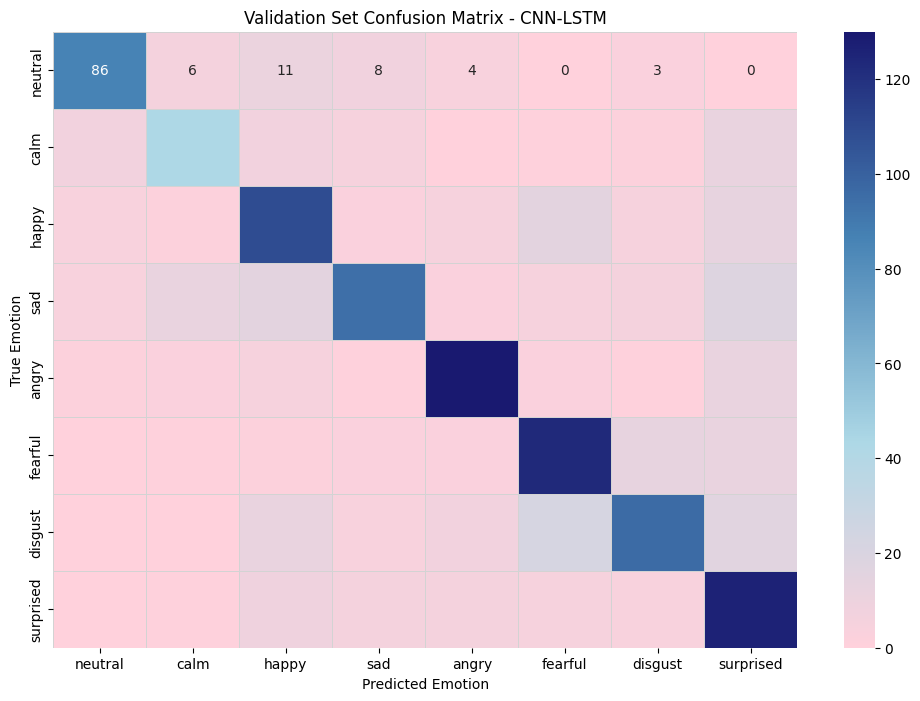


--- Validation Set Predicted Emotions Accuracy (Per Class) for CNN-LSTM ---
neutral: 0.7288
calm: 0.5584
happy: 0.6987
sad: 0.5987
angry: 0.8280
fearful: 0.7834
disgust: 0.6115
surprised: 0.8025


--- Evaluating CNN-LSTM on TEST Set ---
36/36 - 4s - 106ms/step - categorical_accuracy: 0.6972 - loss: 1.5220
Test Loss (CNN-LSTM): 1.5220
Test Accuracy (CNN-LSTM): 0.6972

--- Generating Test Confusion Matrix for CNN-LSTM ---
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step


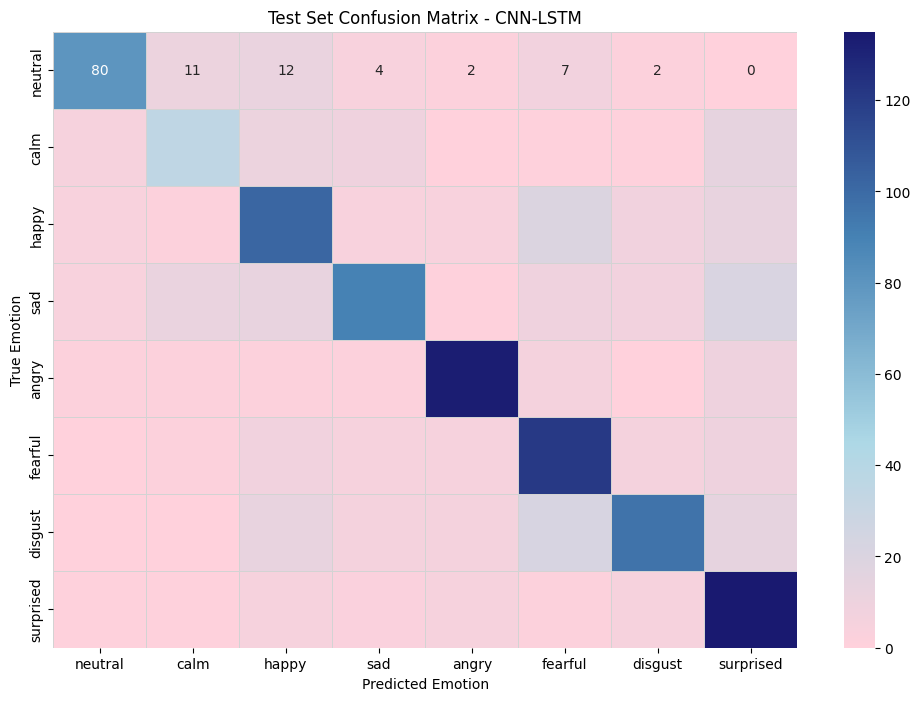


--- Test Set Predicted Emotions Accuracy (Per Class) for CNN-LSTM ---
neutral: 0.6780
calm: 0.4605
happy: 0.6497
sad: 0.5732
angry: 0.8471
fearful: 0.7707
disgust: 0.6115
surprised: 0.8599

--- Plotting True Label Distribution in Test Set for CNN-LSTM ---


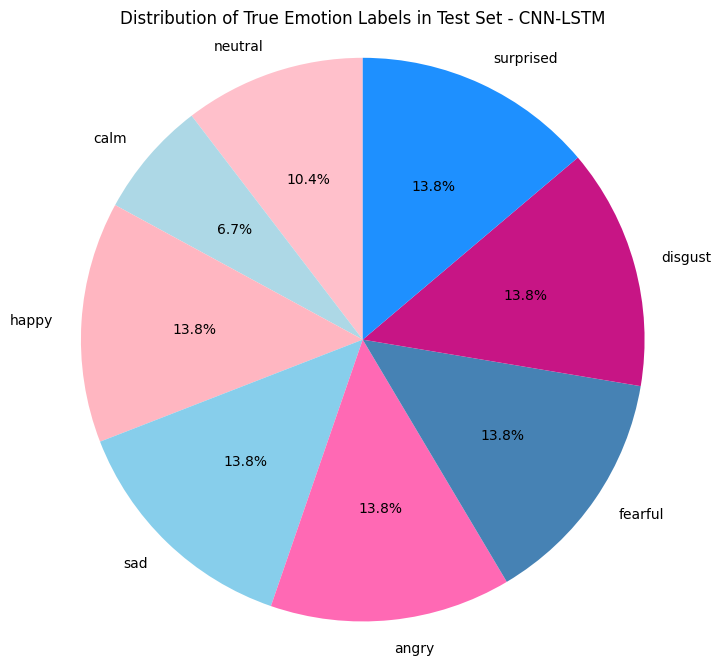


--- Plotting Precision, Recall, F1-Score Per Class (Test Set) for CNN-LSTM ---


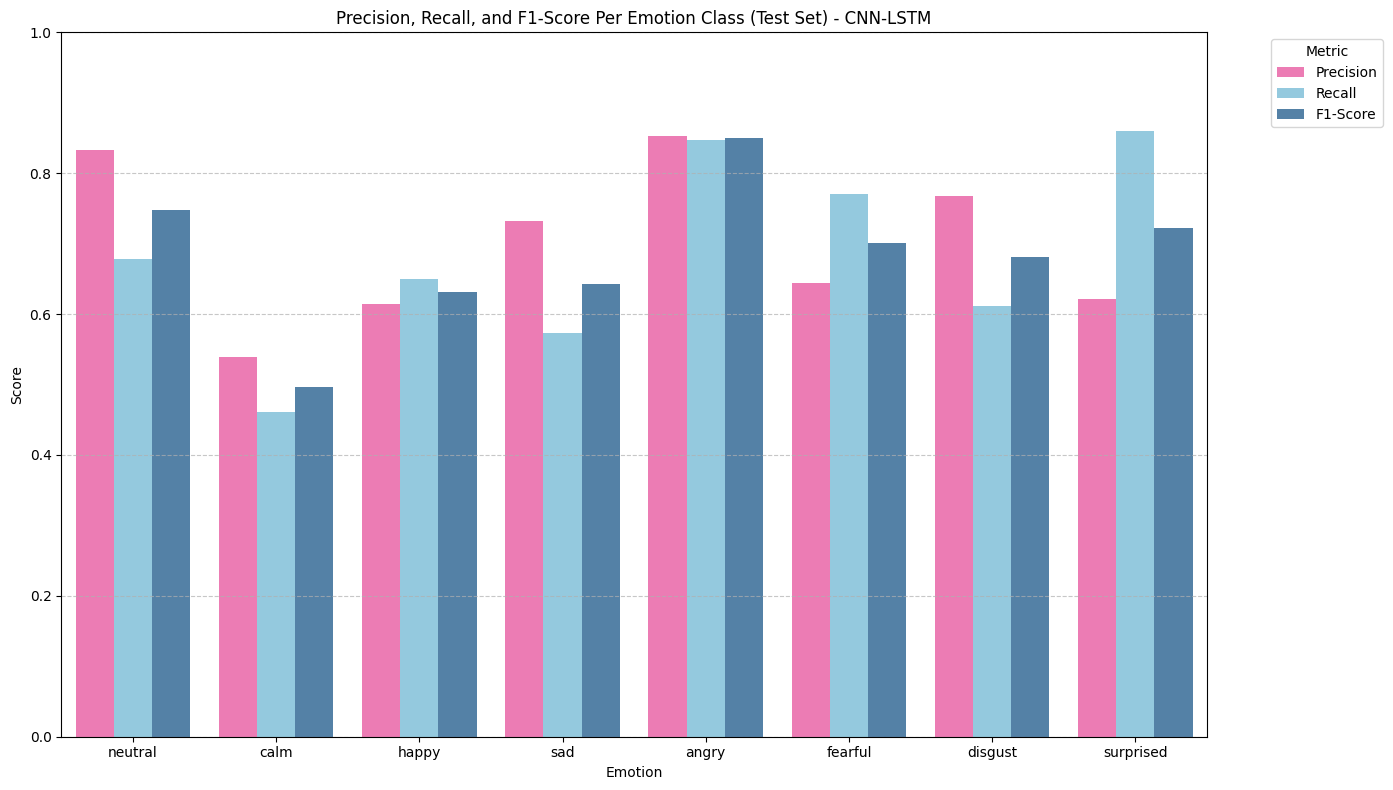


--- Evaluating LSTM-Attention ---

--- Reconstructing LSTM-Attention Architecture ---

--- Loading best weights from C:\Users\chenz\Documents\lstm_attention_best_weights.weights.h5 for LSTM-Attention ---
Model weights for LSTM-Attention loaded successfully.

--- LSTM-Attention Model Summary ---


Model: "LSTM_Attention_Model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_features      │ (None, 716, 768)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bi_lstm_1           │ (None, 716, 128)  │    426,496 │ input_features[0… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_norm_1        │ (None, 716, 128)  │        512 │ bi_lstm_1[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 716, 128)  │          0 │ batch_norm_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ self_attention_lay… │ (None, 716, 128)  │          0 │ dropout_1[0][0],  │
│ (Attention)         │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bi_lstm_2           │ (None, 64)        │     41,216 │ self_attention_l… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_norm_2        │ (None, 64)        │        256 │ bi_lstm_2[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ batch_norm_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_dense        │ (None, 8)         │        520 │ dropout_2[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 469,000 (1.79 MB)

 Trainable params: 468,616 (1.79 MB)

 Non-trainable params: 384 (1.50 KB)

Training history for LSTM-Attention loaded successfully.

--- Evaluating LSTM-Attention on Validation Set ---
36/36 - 11s - 297ms/step - categorical_accuracy: 0.7069 - loss: 1.5742
Validation Loss (LSTM-Attention): 1.5742
Validation Accuracy (LSTM-Attention): 0.7069

--- Generating Validation Confusion Matrix for LSTM-Attention ---
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 246ms/step


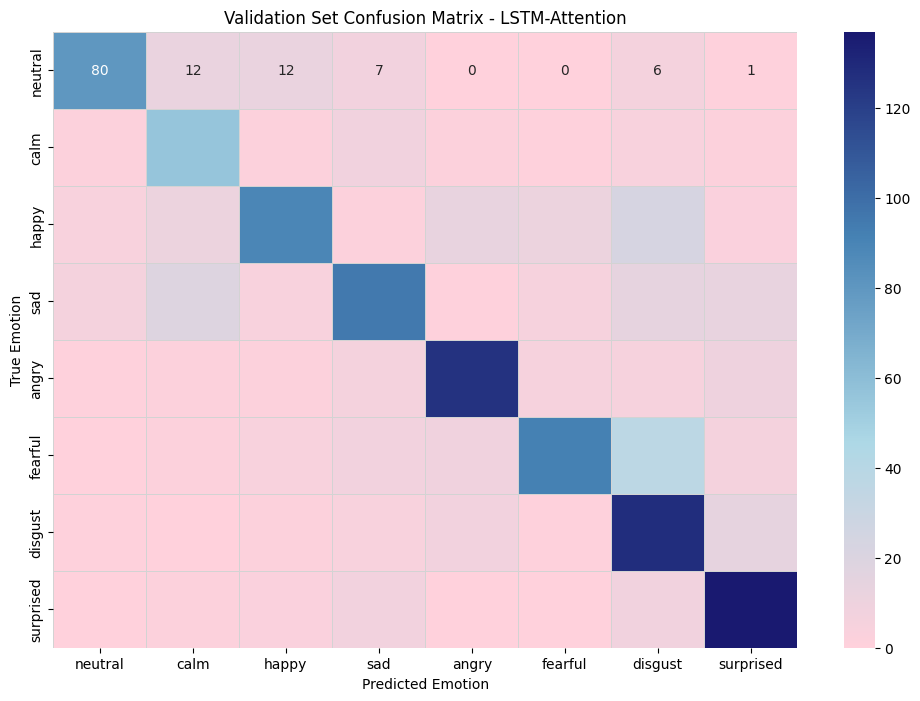


--- Validation Set Predicted Emotions Accuracy (Per Class) for LSTM-Attention ---
neutral: 0.6780
calm: 0.7273
happy: 0.5705
sad: 0.6051
angry: 0.8025
fearful: 0.5860
disgust: 0.8153
surprised: 0.8726


--- Evaluating LSTM-Attention on TEST Set ---
36/36 - 8s - 223ms/step - categorical_accuracy: 0.6963 - loss: 1.5976
Test Loss (LSTM-Attention): 1.5976
Test Accuracy (LSTM-Attention): 0.6963

--- Generating Test Confusion Matrix for LSTM-Attention ---
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 229ms/step


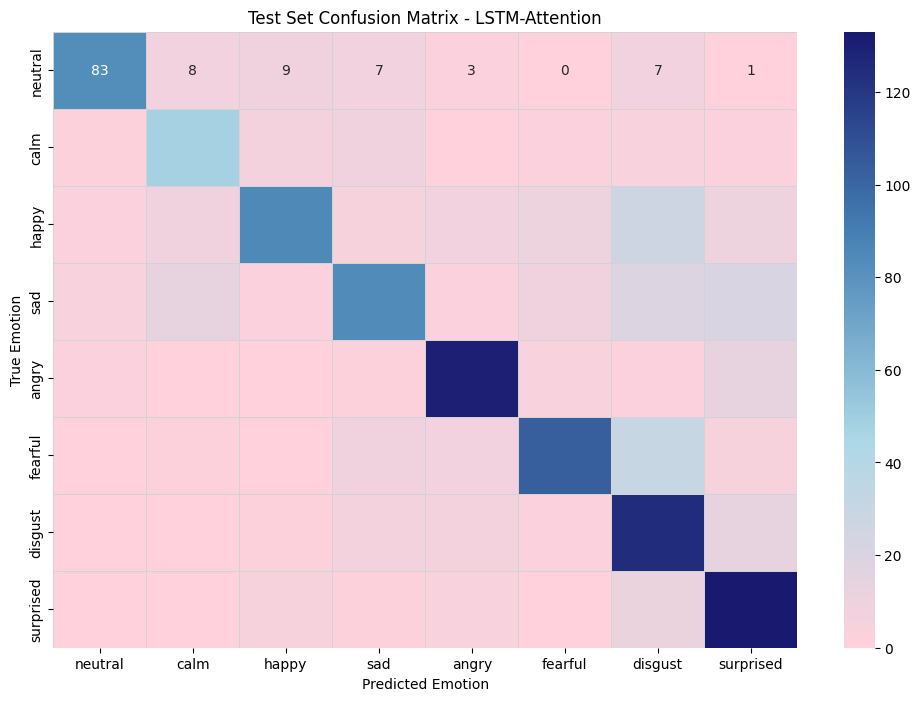


--- Test Set Predicted Emotions Accuracy (Per Class) for LSTM-Attention ---
neutral: 0.7034
calm: 0.6316
happy: 0.5414
sad: 0.5350
angry: 0.8280
fearful: 0.6561
disgust: 0.7962
surprised: 0.8471

--- Plotting True Label Distribution in Test Set for LSTM-Attention ---


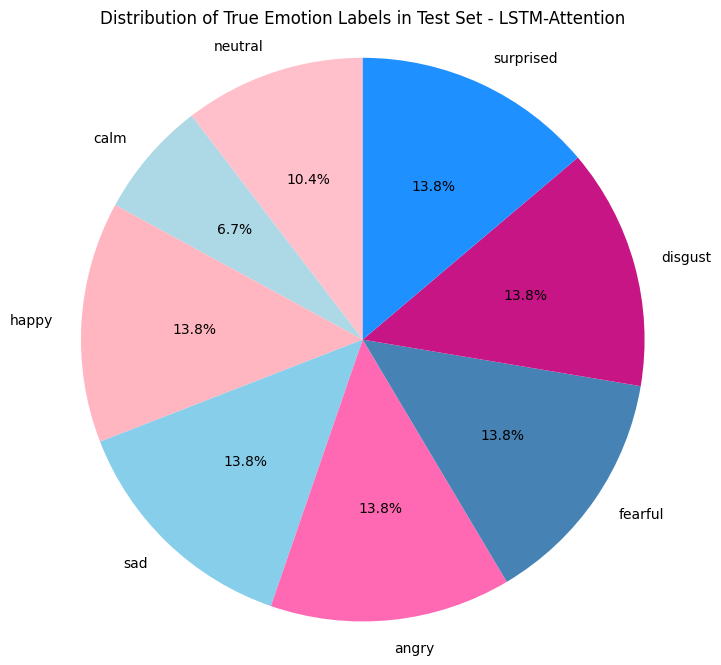


--- Plotting Precision, Recall, F1-Score Per Class (Test Set) for LSTM-Attention ---


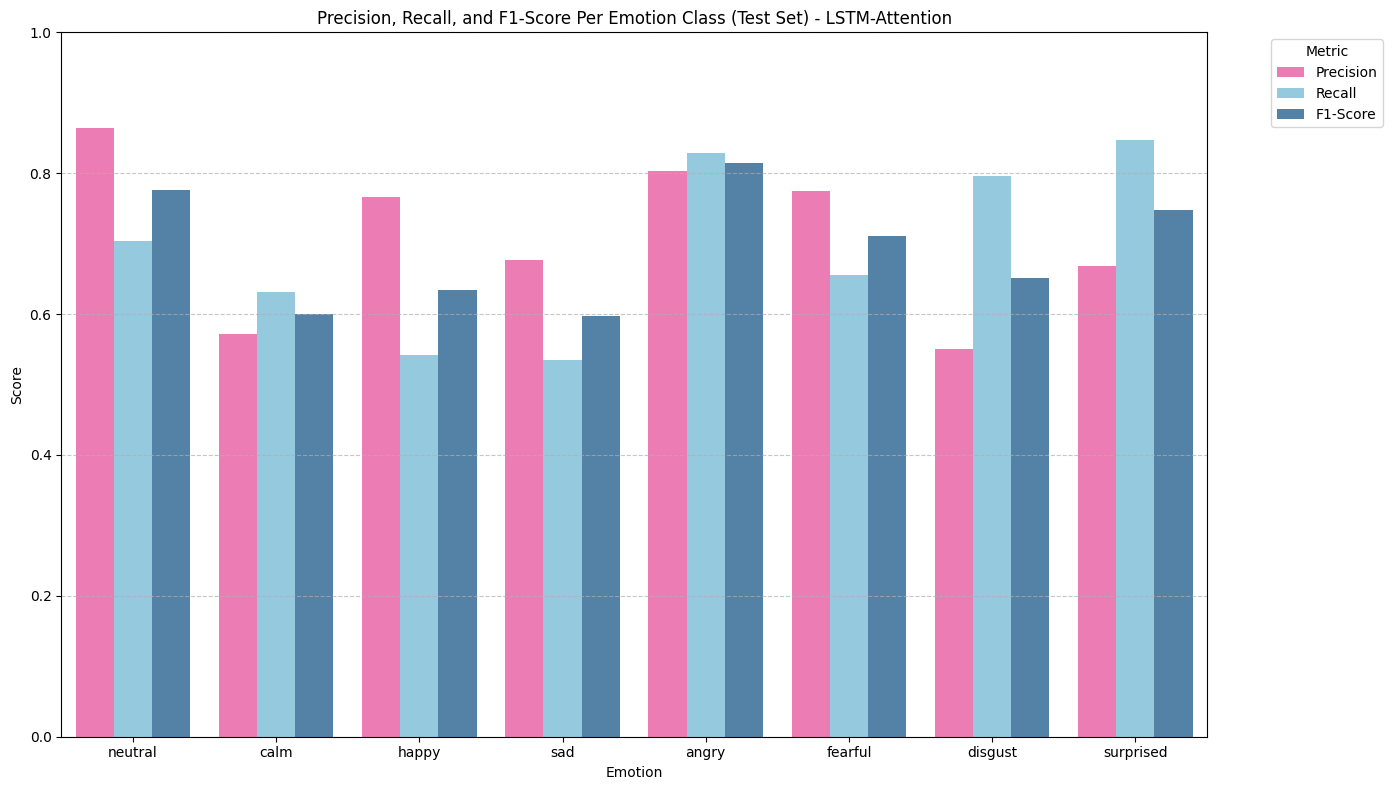



--- Overall Model Comparison ---

--- Plotting Combined Training Histories ---


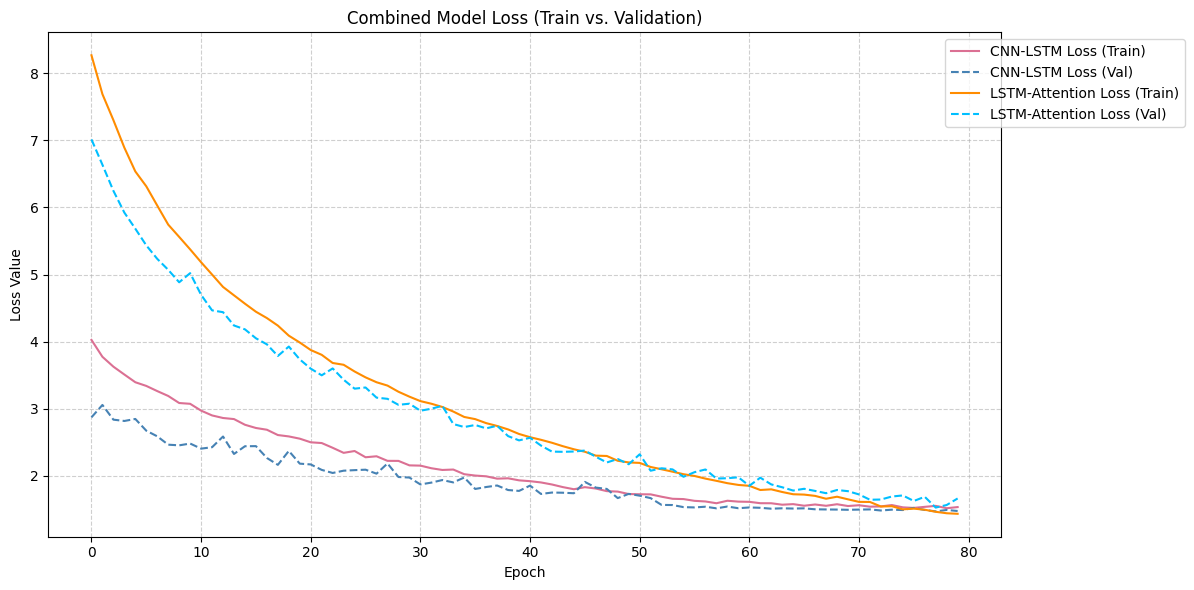

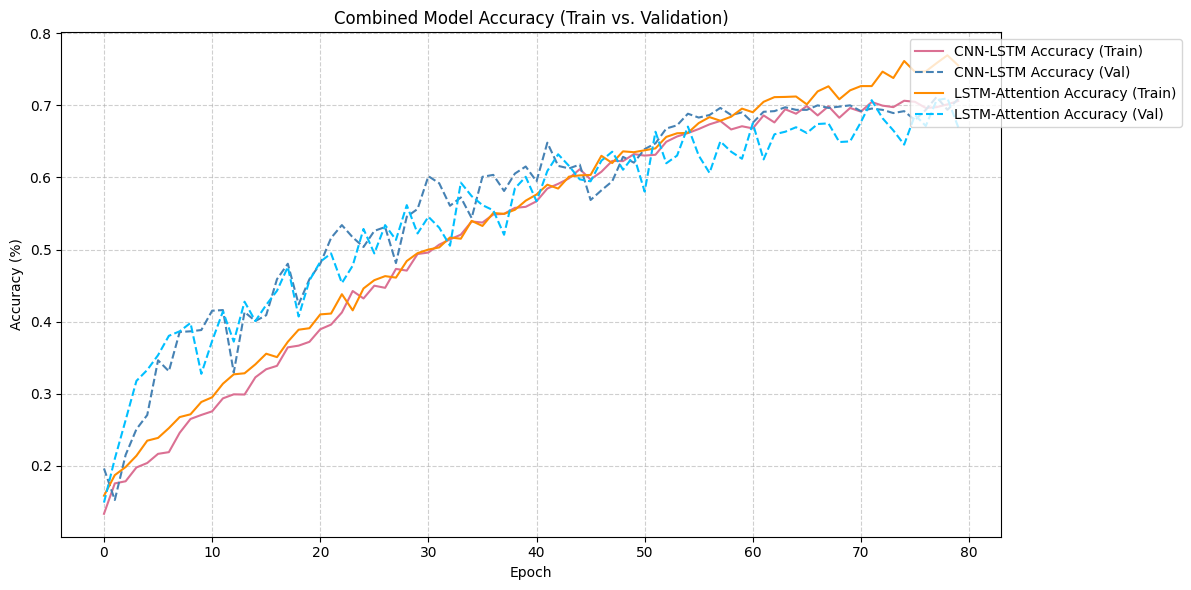


--- Summary of Test Set Performance ---
         Model Test Accuracy Macro Avg Precision Macro Avg Recall Macro Avg F1-Score Weighted Avg Precision Weighted Avg Recall Weighted Avg F1-Score
      CNN-LSTM        0.6972              0.7005           0.6813             0.6841                 0.7075              0.6972                0.6953
LSTM-Attention        0.6963              0.7094           0.6923             0.6914                 0.7139              0.6963                0.6951

--- Comparison Complete ---


In [4]:
import os
import numpy as np
import h5py
from tensorflow.keras.utils import to_categorical
from keras.models import Model, Sequential # Import both Model (for Functional API) and Sequential
from keras import layers # For defining the model structure
from keras.layers import Input, Bidirectional, LSTM, Dense, BatchNormalization, Dropout, Attention, Conv1D, MaxPooling1D # Specific layers
from keras import regularizers
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from sklearn.metrics import confusion_matrix, classification_report
import pickle

# --- HDF5 File and Indices Paths ---
H5_FILE_PATH = os.path.join(r"C:\Users\chenz\Documents", 'emotion_features.h5')
base_path = r"C:\Users\chenz\Documents"

val_indices_path = os.path.join(base_path, 'val_indices.npy')
test_indices_path = os.path.join(base_path, 'test_indices.npy')
labels_mapping_path = os.path.join(base_path, 'labels_mapping.npy')

# --- Load Indices and Labels Mapping ---
print("Loading split indices and labels mapping...")
try:
    val_indices = np.load(val_indices_path)
    test_indices = np.load(test_indices_path)
    labels_map = np.load(labels_mapping_path)
    num_output_classes = len(labels_map)

    with h5py.File(H5_FILE_PATH, 'r') as hf_temp:
        sample_feature_shape = hf_temp['X_wav2vec2_features'].shape[1:]
        input_timesteps = sample_feature_shape[0]
        input_features = sample_feature_shape[1]

except FileNotFoundError as e:
    print(f"Error: Required .npy file not found: {e}. Please ensure the data preparation and index splitting scripts were run successfully.")
    exit()
except Exception as e:
    print(f"An error occurred while loading data for evaluation setup: {e}")
    exit()

print(f"Model Input Timesteps: {input_timesteps}")
print(f"Model Input Features: {input_features}")
print(f"Number of Output Classes: {num_output_classes}")

# Define the emotion labels for plotting (ensure this matches your labels_map order)
emotion_labels = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']

# --- Model Architecture Builder Functions ---

def build_cnn_lstm_model(input_timesteps, input_features, num_output_classes):
    """Reconstructs the CNN-LSTM model architecture."""
    model = Sequential(name='CNN-LSTM_Model')
    model.add(Conv1D(filters=128, kernel_size=5, activation='relu', kernel_regularizer=regularizers.l2(0.001),
                     input_shape=(input_timesteps, input_features)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.3))

    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.3))

    model.add(Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=regularizers.l2(0.001))))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Bidirectional(LSTM(32, kernel_regularizer=regularizers.l2(0.001))))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(num_output_classes, activation='softmax', kernel_regularizer=regularizers.l2(0.005)))
    return model

def build_lstm_attention_model(input_timesteps, input_features, num_output_classes):
    """Reconstructs the LSTM with Attention model architecture."""
    input_tensor = Input(shape=(input_timesteps, input_features), name='input_features')

    x = Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=regularizers.l2(0.005)), name='bi_lstm_1')(input_tensor)
    x = BatchNormalization(name='batch_norm_1')(x)
    x = Dropout(0.5, name='dropout_1')(x)

    attention_output = Attention(name='self_attention_layer')([x, x])

    x = Bidirectional(LSTM(32, kernel_regularizer=regularizers.l2(0.005)), name='bi_lstm_2')(attention_output)
    x = BatchNormalization(name='batch_norm_2')(x)
    x = Dropout(0.6, name='dropout_2')(x)

    output_tensor = Dense(num_output_classes, activation='softmax', kernel_regularizer=regularizers.l2(0.01), name='output_dense')(x)

    model = Model(inputs=input_tensor, outputs=output_tensor, name='LSTM_Attention_Model')
    return model

# --- Model Configurations for Comparison ---
model_configs = [
    {
        'name': 'CNN-LSTM',
        'weights_path': os.path.join(base_path, 'best_weights.weights.h5'),
        'history_path': os.path.join(base_path, 'training_history.pkl'),
        'builder_func': build_cnn_lstm_model
    },
    {
        'name': 'LSTM-Attention',
        'weights_path': os.path.join(base_path, 'lstm_attention_best_weights.weights.h5'),
        'history_path': os.path.join(base_path, 'lstm_attention_training_history.pkl'),
        'builder_func': build_lstm_attention_model
    }
]

# --- Define Custom Color Palettes for Pink-Blue Theme ---
colors_for_heatmap = ["#FFD1DC", "#ADD8E6", "#4682B4", "#191970"]
custom_pink_blue_cmap = LinearSegmentedColormap.from_list("PinkBlue", colors_for_heatmap, N=256)
pie_colors = ['#FFC0CB', '#ADD8E6', '#FFB6C1', '#87CEEB', '#FF69B4', '#4682B4', '#C71585', '#1E90FF']
bar_palette = {
    'Precision': '#FF69B4',
    'Recall': '#87CEEB',
    'F1-Score': '#4682B4'
}

# Colors for combined history plots
model_colors = {
    'CNN-LSTM': {'train': '#DB7093', 'val': '#4682B4'}, # PaleVioletRed, SteelBlue
    'LSTM-Attention': {'train': '#FF8C00', 'val': '#00BFFF'} # DarkOrange, DeepSkyBlue
}

# --- Data Loading for Post-Training Evaluation ---
print("\n--- Loading Validation and Test Data for Evaluation ---")
X_val_list = []
y_val_raw_list = []
X_test_list = []
y_test_raw_list = []

with h5py.File(H5_FILE_PATH, 'r') as hf:
    X_dataset = hf['X_wav2vec2_features']
    Y_dataset = hf['Y_labels']
    for idx in val_indices:
        X_val_list.append(X_dataset[idx])
        y_val_raw_list.append(Y_dataset[idx])
    for idx in test_indices:
        X_test_list.append(X_dataset[idx])
        y_test_raw_list.append(Y_dataset[idx])

X_val = np.array(X_val_list)
y_val = np.array(y_val_raw_list)
y_val_one_hot = to_categorical(y_val, num_classes=num_output_classes)

X_test = np.array(X_test_list)
y_test = np.array(y_test_raw_list)
y_test_one_hot = to_categorical(y_test, num_classes=num_output_classes)

print("Validation and Test Data Loaded for Evaluation.")

# --- DIAGNOSTIC: Check True Label Distribution in Evaluation Sets ---
print("\n--- DIAGNOSTIC: True Label Distribution in Validation Set ---")
unique_val_labels, counts_val = np.unique(y_val, return_counts=True)
total_val_samples = len(y_val)
for label_id, count in zip(unique_val_labels, counts_val):
    if label_id < len(emotion_labels):
        print(f"  {emotion_labels[label_id]}: {count} samples ({count/total_val_samples:.2%})")
    else:
        print(f"  Unknown Label ID {label_id}: {count} samples")

print("\n--- DIAGNOSTIC: True Label Distribution in Test Set ---")
unique_test_labels, counts_test = np.unique(y_test, return_counts=True)
total_test_samples = len(y_test)
for label_id, count in zip(unique_test_labels, counts_test):
    if label_id < len(emotion_labels):
        print(f"  {emotion_labels[label_id]}: {count} samples ({count/total_test_samples:.2%})")
    else:
        print(f"  Unknown Label ID {label_id}: {count} samples")
# --- END DIAGNOSTIC ---


# --- Store results for comparison ---
all_histories = {}
evaluation_results = []

# --- Loop through each model configuration for evaluation ---
for config in model_configs:
    model_name = config['name']
    weights_path = config['weights_path']
    history_path = config['history_path']
    builder_func = config['builder_func']

    print(f"\n{'='*50}")
    print(f"--- Evaluating {model_name} ---")
    print(f"{'='*50}")

    # Reconstruct and Load the Model
    print(f"\n--- Reconstructing {model_name} Architecture ---")
    model = builder_func(input_timesteps, input_features, num_output_classes)

    print(f"\n--- Loading best weights from {weights_path} for {model_name} ---")
    try:
        model.load_weights(weights_path)
        print(f"Model weights for {model_name} loaded successfully.")
    except Exception as e:
        print(f"Error loading model weights for {model_name} from {weights_path}: {e}")
        print("Skipping evaluation for this model.")
        continue # Skip to the next model if weights cannot be loaded

    model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['categorical_accuracy']
    )
    print(f"\n--- {model_name} Model Summary ---")
    model.summary()

    # Load Training History
    history = None
    try:
        with open(history_path, 'rb') as file_pi:
            history_data = pickle.load(file_pi)
        history = history_data
        all_histories[model_name] = history # Store history for combined plots
        print(f"Training history for {model_name} loaded successfully.")
    except FileNotFoundError:
        print(f"Warning: Training history file not found at {history_path} for {model_name}. Cannot plot individual history.")
    except Exception as e:
        print(f"Error loading training history for {model_name}: {e}")

    # --- Evaluate Model on Validation Set ---
    print(f"\n--- Evaluating {model_name} on Validation Set ---")
    val_loss, val_acc = model.evaluate(X_val, y_val_one_hot, verbose=2)
    print(f"Validation Loss ({model_name}): {val_loss:.4f}")
    print(f"Validation Accuracy ({model_name}): {val_acc:.4f}")

    # Validation Confusion Matrix
    print(f"\n--- Generating Validation Confusion Matrix for {model_name} ---")
    val_predictions = model.predict(X_val)
    y_pred_val_class = np.argmax(val_predictions, axis=1)
    cm_val = confusion_matrix(y_val, y_pred_val_class)
    cm_df_val = pd.DataFrame(cm_val, index=emotion_labels, columns=emotion_labels)
    plt.figure(figsize=(12, 8))
    ax = plt.axes()
    sns.heatmap(cm_df_val, ax=ax, cmap=custom_pink_blue_cmap, fmt="d", annot=True, linewidths=.5, linecolor='lightgray')
    ax.set_title(f'Validation Set Confusion Matrix - {model_name}')
    ax.set_ylabel('True Emotion')
    ax.set_xlabel('Predicted Emotion')
    plt.show()

    # Validation set prediction accuracy rates per class
    print(f"\n--- Validation Set Predicted Emotions Accuracy (Per Class) for {model_name} ---")
    values_val = cm_val.diagonal()
    row_sum_val = np.sum(cm_val, axis=1)
    acc_per_class_val = np.zeros(len(values_val))
    for i in range(len(values_val)):
        if row_sum_val[i] > 0:
            acc_per_class_val[i] = values_val[i] / row_sum_val[i]
    for e in range(0, len(values_val)):
        if row_sum_val[e] > 0:
            print(f"{emotion_labels[e]}: {acc_per_class_val[e]:.4f}")
        else:
            print(f"{emotion_labels[e]}: No true samples in validation set (cannot calculate accuracy)")


    print(f"\n\n--- Evaluating {model_name} on TEST Set ---")
    test_loss, test_acc = model.evaluate(X_test, y_test_one_hot, verbose=2)
    print(f"Test Loss ({model_name}): {test_loss:.4f}")
    print(f"Test Accuracy ({model_name}): {test_acc:.4f}")

    # Test Confusion Matrix
    print(f"\n--- Generating Test Confusion Matrix for {model_name} ---")
    test_predictions = model.predict(X_test)
    y_pred_test_class = np.argmax(test_predictions, axis=1)
    cm_test = confusion_matrix(y_test, y_pred_test_class)
    cm_df_test = pd.DataFrame(cm_test, index=emotion_labels, columns=emotion_labels)
    plt.figure(figsize=(12, 8))
    ax = plt.axes()
    sns.heatmap(cm_df_test, ax=ax, cmap=custom_pink_blue_cmap, fmt="d", annot=True, linewidths=.5, linecolor='lightgray')
    ax.set_title(f'Test Set Confusion Matrix - {model_name}')
    ax.set_ylabel('True Emotion')
    ax.set_xlabel('Predicted Emotion')
    plt.show()

    # Test set prediction accuracy rates per class
    print(f"\n--- Test Set Predicted Emotions Accuracy (Per Class) for {model_name} ---")
    values_test = cm_test.diagonal()
    row_sum_test = np.sum(cm_test, axis=1)
    acc_per_class_test = np.zeros(len(values_test))
    for i in range(len(values_test)):
        if row_sum_test[i] > 0:
            acc_per_class_test[i] = values_test[i] / row_sum_test[i]
    for e in range(0, len(values_test)):
        if row_sum_test[e] > 0:
            print(f"{emotion_labels[e]}: {acc_per_class_test[e]:.4f}")
        else:
            print(f"{emotion_labels[e]}: No true samples in test set (cannot calculate accuracy)")

    # Generate classification report for detailed metrics
    report = classification_report(y_test, y_pred_test_class, target_names=emotion_labels, output_dict=True, zero_division=0)
    evaluation_results.append({
        'Model': model_name,
        'Test Loss': test_loss,
        'Test Accuracy': test_acc,
        'Classification Report': report
    })

    # --- NEW GRAPHS FOR ENHANCED EVALUATION (for current model) ---

    # 1. Pie Chart: Distribution of True Labels in Test Set
    print(f"\n--- Plotting True Label Distribution in Test Set for {model_name} ---")
    true_label_counts = pd.Series(y_test).value_counts().sort_index()
    plt.figure(figsize=(8, 8))
    pie_labels = [emotion_labels[i] for i in true_label_counts.index]
    plt.pie(true_label_counts, labels=pie_labels, autopct='%1.1f%%', startangle=90, colors=pie_colors)
    plt.title(f'Distribution of True Emotion Labels in Test Set - {model_name}')
    plt.axis('equal')
    plt.show()

    # 2. Grouped Bar Chart: Precision, Recall, F1-Score Per Class (Test Set)
    print(f"\n--- Plotting Precision, Recall, F1-Score Per Class (Test Set) for {model_name} ---")
    metrics_df = pd.DataFrame()
    for label_name in emotion_labels:
        if label_name in report and isinstance(report[label_name], dict):
            metrics_df = pd.concat([metrics_df, pd.DataFrame({
                'Metric': ['Precision', 'Recall', 'F1-Score'],
                'Value': [report[label_name]['precision'], report[label_name]['recall'], report[label_name]['f1-score']],
                'Emotion': label_name
            })], ignore_index=True)
        elif label_name not in report:
            print(f"Warning: Label '{label_name}' not found in classification report for {model_name}. It might not have appeared in test set true labels.")

    plt.figure(figsize=(14, 8))
    sns.barplot(x='Emotion', y='Value', hue='Metric', data=metrics_df, palette=bar_palette)
    plt.title(f'Precision, Recall, and F1-Score Per Emotion Class (Test Set) - {model_name}')
    plt.ylabel('Score')
    plt.xlabel('Emotion')
    plt.ylim(0, 1)
    plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

print("\n\n--- Overall Model Comparison ---")

# --- Combined History Plots ---
if all_histories:
    print("\n--- Plotting Combined Training Histories ---")
    plt.figure(figsize=(12, 6))
    for model_name, history_data in all_histories.items():
        if 'loss' in history_data and 'val_loss' in history_data:
            plt.plot(history_data['loss'], label=f'{model_name} Loss (Train)', color=model_colors[model_name]['train'], linestyle='-')
            plt.plot(history_data['val_loss'], label=f'{model_name} Loss (Val)', color=model_colors[model_name]['val'], linestyle='--')
    plt.title('Combined Model Loss (Train vs. Validation)')
    plt.ylabel('Loss Value')
    plt.xlabel('Epoch')
    plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1))
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 6))
    for model_name, history_data in all_histories.items():
        if 'categorical_accuracy' in history_data and 'val_categorical_accuracy' in history_data:
            plt.plot(history_data['categorical_accuracy'], label=f'{model_name} Accuracy (Train)', color=model_colors[model_name]['train'], linestyle='-')
            plt.plot(history_data['val_categorical_accuracy'], label=f'{model_name} Accuracy (Val)', color=model_colors[model_name]['val'], linestyle='--')
    plt.title('Combined Model Accuracy (Train vs. Validation)')
    plt.ylabel('Accuracy (%)')
    plt.xlabel('Epoch')
    plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1))
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
else:
    print("No training histories available for combined plots.")

# --- Summary Table of Test Set Performance ---
print("\n--- Summary of Test Set Performance ---")
summary_data = []
for result in evaluation_results:
    report = result['Classification Report']
    summary_data.append({
        'Model': result['Model'],
        'Test Accuracy': f"{result['Test Accuracy']:.4f}",
        'Macro Avg Precision': f"{report['macro avg']['precision']:.4f}",
        'Macro Avg Recall': f"{report['macro avg']['recall']:.4f}",
        'Macro Avg F1-Score': f"{report['macro avg']['f1-score']:.4f}",
        'Weighted Avg Precision': f"{report['weighted avg']['precision']:.4f}",
        'Weighted Avg Recall': f"{report['weighted avg']['recall']:.4f}",
        'Weighted Avg F1-Score': f"{report['weighted avg']['f1-score']:.4f}"
    })
summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

print("\n--- Comparison Complete ---")



# LSTM Real Time Application

Output directory 'C:\Users\chenz\Documents' ensured to exist.

Attempting to define model architecture and load weights from: C:\Users\chenz\Documents\lstm_attention_best_weights.weights.h5
Model architecture defined and weights loaded successfully!

--- Loaded Keras Model Summary (from weights) ---


Model: "LSTM_Attention_Model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_features      │ (None, 716, 768)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bi_lstm_1           │ (None, 716, 128)  │    426,496 │ input_features[0… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_norm_1        │ (None, 716, 128)  │        512 │ bi_lstm_1[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 716, 128)  │          0 │ batch_norm_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ self_attention_lay… │ (None, 716, 128)  │          0 │ dropout_1[0][0],  │
│ (Attention)         │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bi_lstm_2           │ (None, 64)        │     41,216 │ self_attention_l… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_norm_2        │ (None, 64)        │        256 │ bi_lstm_2[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ batch_norm_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_dense        │ (None, 8)         │        520 │ dropout_2[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 469,000 (1.79 MB)

 Trainable params: 468,616 (1.79 MB)

 Non-trainable params: 384 (1.50 KB)

Loading Wav2Vec2 feature extractor and model: facebook/wav2vec2-base-960h...


Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Wav2Vec2 model and feature extractor loaded successfully!
Wav2Vec2 model device: CPU
INFO: Attempting to open audio stream.
INFO: Default input device: Microphone Array (IntelÂ® Smart  (Index: 1)
INFO: Audio stream opened successfully with RATE=24414, CHUNK=512, FORMAT=2.
DEBUG: Listening for initial sound for 95 chunks (0.04 seconds)...
INFO: Recording and analysis thread started.
INFO: Sound detected during initial listen (chunk 0).
DEBUG: Starting new segment recording (338 chunks).
DEBUG: Segment saved to 'C:\Users\chenz\Documents\output_segment.wav' (Size: 692224 bytes).
DEBUG: Loaded audio from 'output_segment.wav' with sample rate 24414. Shape: (173056,)
Resampling audio from 24414 Hz to 16000 Hz for Wav2Vec2 processing.
DEBUG: Resampled audio shape: (113415,)
DEBUG: Wav2Vec2 feature extractor output (input_values) shape: torch.Size([1, 113415])
DEBUG: Extracted Wav2Vec2 features. Shape: (354, 768)
DEBUG: Padded features from 354 to 716 timesteps with 362 zeros.
DEBUG: Final pre

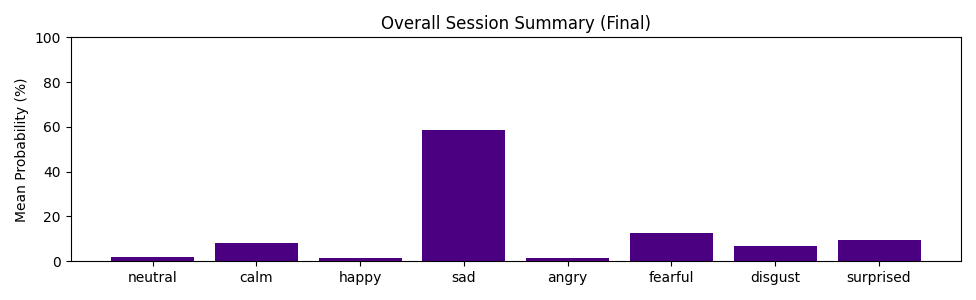


Displaying consecutive segment emotion trend plot from: C:\Users\chenz\Documents\consecutive_segments_plot.png


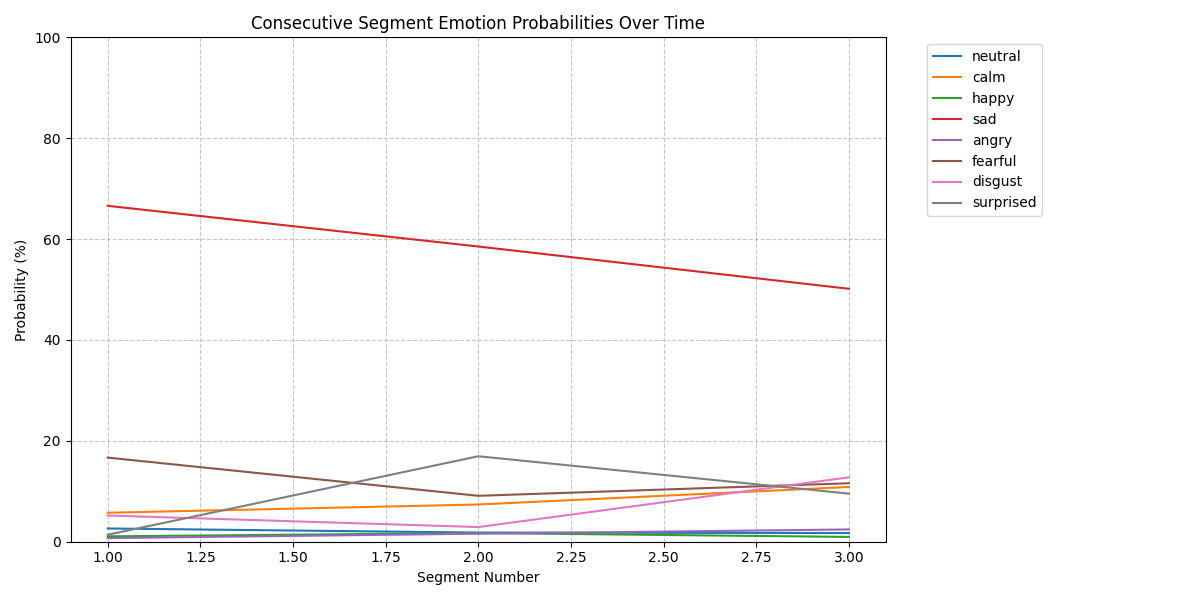

In [26]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg, NavigationToolbar2Tk
import tkinter as tk
from tkinter import ttk, messagebox
import threading
import time
import sys
import wave # Added for wave.open in _record_and_analyze

# For displaying image in Jupyter notebook after Tkinter closes
from IPython.display import Image, display

# Important: Use tensorflow.keras for consistency if your model was saved with TF backend.
import tensorflow as tf
from tensorflow.keras.models import Model # Using Model for Functional API
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional, BatchNormalization, Attention # Added Attention
from tensorflow.keras import regularizers

import librosa

# Imports for Wav2Vec2
from transformers import AutoFeatureExtractor, Wav2Vec2Model
import torch
import pyaudio # Imported here as it's used globally and in SERApp

# --- Audio Recording Parameters ---
RATE = 24414 # This is your microphone's sample rate
CHUNK = 512
RECORD_SECONDS_PER_SEGMENT = 7.1
FORMAT = pyaudio.paInt32
CHANNELS = 1

OUTPUT_DIRECTORY = r"C:\Users\chenz\Documents"
WAVE_OUTPUT_FILE = os.path.join(OUTPUT_DIRECTORY, "output_segment.wav")
# Define a path for the summary plot image
SUMMARY_PLOT_IMAGE_PATH = os.path.join(OUTPUT_DIRECTORY, "session_summary_plot.png")


# Ensure output directory exists before any file operations
os.makedirs(OUTPUT_DIRECTORY, exist_ok=True)
print(f"Output directory '{OUTPUT_DIRECTORY}' ensured to exist.")

# --- MODIFIED: Path now points to the LSTM-Attention model weights ---
BEST_WEIGHTS_PATH = os.path.join(OUTPUT_DIRECTORY, 'lstm_attention_best_weights.weights.h5')

emotions = {
    0 : 'neutral',
    1 : 'calm',
    2 : 'happy',
    3 : 'sad',
    4 : 'angry',
    5 : 'fearful',
    6 : 'disgust',
    7 : 'surprised'
}
emo_list = list(emotions.values())

# --- Model Parameters (UPDATED for Wav2Vec2) ---
# **CRITICAL: This must match TARGET_WAV2VEC2_FEATURE_LENGTH in whisper_api.py
# and your training script.**
MODEL_INPUT_TIMESTEPS = 716
MODEL_INPUT_FEATURES = 768
NUM_OUTPUT_CLASSES = len(emotions)

# --- Wav2Vec2 Global Objects ---
# IMPORTANT: This must match the model used for feature extraction during training!
WAV2VEC2_MODEL_NAME = "facebook/wav2vec2-base-960h" # Common base model
feature_extractor = None
wav2vec2_model = None
WAV2VEC2_TARGET_SR = 16000 # Most Wav2Vec2 models expect 16kHz audio

# --- Global Flag for Critical Error ---
CRITICAL_ERROR_OCCURRED = False

# --- DummyModel Definition (MOVED TO GLOBAL SCOPE) ---
# This class is now globally defined so it's always accessible,
# regardless of whether the actual Keras model loading succeeds or fails.
class DummyModel:
    def predict(self, x):
        probs = np.random.rand(1, len(emotions))
        probs = probs / np.sum(probs)
        return probs

def load_wav2vec2_components():
    global feature_extractor, wav2vec2_model, CRITICAL_ERROR_OCCURRED
    try:
        print(f"Loading Wav2Vec2 feature extractor and model: {WAV2VEC2_MODEL_NAME}...")
        feature_extractor = AutoFeatureExtractor.from_pretrained(WAV2VEC2_MODEL_NAME)
        wav2vec2_model = Wav2Vec2Model.from_pretrained(WAV2VEC2_MODEL_NAME)
        wav2vec2_model.eval() # Set model to evaluation mode
        print("Wav2Vec2 model and feature extractor loaded successfully!")
        print(f"Wav2Vec2 model device: {'CUDA' if torch.cuda.is_available() else 'CPU'}")
    except Exception as e:
        print(f"CRITICAL ERROR: Could not load Wav2Vec2 components: {e}")
        print("Please ensure 'transformers' and 'torch' are installed and the model name is correct.")
        print("This is a fatal error. The application cannot proceed without Wav2Vec2.")
        CRITICAL_ERROR_OCCURRED = True
        feature_extractor = None
        wav2vec2_model = None

def preprocess(file_path):
    global feature_extractor, wav2vec2_model
    if feature_extractor is None or wav2vec2_model is None:
        print("Wav2Vec2 model not loaded. Cannot preprocess. Returning zeros.")
        return np.zeros((1, MODEL_INPUT_TIMESTEPS, MODEL_INPUT_FEATURES), dtype=np.float32)

    try:
        y, sr = librosa.load(file_path, sr=None, mono=True) # Load with original SR, then resample
        print(f"DEBUG: Loaded audio from '{os.path.basename(file_path)}' with sample rate {sr}. Shape: {y.shape}")

        if sr != WAV2VEC2_TARGET_SR:
            print(f"Resampling audio from {sr} Hz to {WAV2VEC2_TARGET_SR} Hz for Wav2Vec2 processing.")
            y = librosa.resample(y=y, orig_sr=sr, target_sr=WAV2VEC2_TARGET_SR)
            sr = WAV2VEC2_TARGET_SR
            print(f"DEBUG: Resampled audio shape: {y.shape}")

        inputs = feature_extractor(y, sampling_rate=sr, return_tensors="pt")
        print(f"DEBUG: Wav2Vec2 feature extractor output (input_values) shape: {inputs.input_values.shape}")

        with torch.no_grad():
            outputs = wav2vec2_model(**inputs)
            features = outputs.last_hidden_state.squeeze(0).numpy()

        print(f"DEBUG: Extracted Wav2Vec2 features. Shape: {features.shape}")

        current_timesteps = features.shape[0]

        if current_timesteps > MODEL_INPUT_TIMESTEPS:
            final_features = features[:MODEL_INPUT_TIMESTEPS, :]
            print(f"DEBUG: Truncated features from {current_timesteps} to {MODEL_INPUT_TIMESTEPS} timesteps.")
        elif current_timesteps < MODEL_INPUT_TIMESTEPS:
            pad_width = MODEL_INPUT_TIMESTEPS - current_timesteps
            final_features = np.pad(features, ((0, pad_width), (0, 0)), mode='constant', constant_values=0)
            print(f"DEBUG: Padded features from {current_timesteps} to {MODEL_INPUT_TIMESTEPS} timesteps with {pad_width} zeros.")
        else:
            final_features = features
            print(f"DEBUG: Features already have {MODEL_INPUT_TIMESTEPS} timesteps.")

        final_input_shape = np.expand_dims(final_features, axis=0)
        print(f"DEBUG: Final preprocessed input shape for Keras model: {final_input_shape.shape}")

        return final_input_shape

    except Exception as e:
        print(f"CRITICAL ERROR in Wav2Vec2 preprocess function: {e}")
        import traceback
        traceback.print_exc()
        return np.zeros((1, MODEL_INPUT_TIMESTEPS, MODEL_INPUT_FEATURES), dtype=np.float32)

def is_silent(audio_data_np, threshold=1000):
    current_max_amplitude = np.max(np.abs(audio_data_np))
    is_silence = current_max_amplitude < threshold
    return is_silence

model = None

print(f"\nAttempting to define model architecture and load weights from: {BEST_WEIGHTS_PATH}")

try:
    # --- MODIFIED: RECONSTRUCTING LSTM-ATTENTION MODEL ARCHITECTURE ---
    # This must exactly match the build_lstm_attention_model function from your training/evaluation script
    inputs = Input(shape=(MODEL_INPUT_TIMESTEPS, MODEL_INPUT_FEATURES), name='input_features')

    x = Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=regularizers.l2(0.005)), name='bi_lstm_1')(inputs)
    x = BatchNormalization(name='batch_norm_1')(x)
    x = Dropout(0.5, name='dropout_1')(x)

    attention_output = Attention(name='self_attention_layer')([x, x])

    x = Bidirectional(LSTM(32, kernel_regularizer=regularizers.l2(0.005)), name='bi_lstm_2')(attention_output)
    x = BatchNormalization(name='batch_norm_2')(x)
    x = Dropout(0.6, name='dropout_2')(x)

    outputs = Dense(NUM_OUTPUT_CLASSES, activation='softmax', kernel_regularizer=regularizers.l2(0.01), name='output_dense')(x)

    model = Model(inputs=inputs, outputs=outputs, name='LSTM_Attention_Model')
    # ---------------------------------------------------------------------

    model.load_weights(BEST_WEIGHTS_PATH)
    print("Model architecture defined and weights loaded successfully!")

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

    print("\n--- Loaded Keras Model Summary (from weights) ---")
    model.summary()

except FileNotFoundError:
    print(f"\nERROR: Model weights file not found at {BEST_WEIGHTS_PATH}.")
    print("Please ensure the training script saved 'lstm_attention_best_weights.weights.h5' to this location.")
    print("The application will run with a DummyModel, producing random predictions.")
    model = DummyModel()
    CRITICAL_ERROR_OCCURRED = True

except Exception as e:
    print(f"\nERROR: An unexpected error occurred during Keras model definition or weight loading: {e}")
    print("This might be due to an incompatible Keras/TensorFlow version, or issues with the weights file's structure.")
    import traceback
    traceback.print_exc()
    model = DummyModel()
    CRITICAL_ERROR_OCCURRED = True

class SERApp:
    def __init__(self, master):
        self.master = master
        master.title("Real-time Speech Emotion Recognition")
        # --- MODIFIED: Increased height for two plots ---
        master.geometry("1000x800")
        master.resizable(False, False)

        self.p = pyaudio.PyAudio()
        self.stream = None
        self.recording_thread = None
        self.stop_recording_event = threading.Event()
        self.session_start_time = None
        self.total_predictions = []
        self.final_summary_image_path = None # Store the path to the saved image

        self.create_widgets()
        master.protocol("WM_DELETE_WINDOW", self.on_closing)

        if CRITICAL_ERROR_OCCURRED:
            self.start_button.config(state=tk.DISABLED)
            self.status_label.config(text="FATAL ERROR during setup. Check console for details.", foreground="red")
            messagebox.showerror("Fatal Setup Error", "The application encountered a critical error during startup (e.g., model loading, Wav2Vec2 components). Please check the console/Jupyter output for details. The application cannot proceed.")


    def create_widgets(self):
        control_frame = ttk.Frame(self.master, padding="10")
        control_frame.pack(side=tk.TOP, fill=tk.X)

        self.start_button = ttk.Button(control_frame, text="Start Analysis", command=self.start_analysis)
        self.start_button.pack(side=tk.LEFT, padx=5, pady=5)

        self.stop_button = ttk.Button(control_frame, text="Stop Analysis", command=self.stop_analysis, state=tk.DISABLED)
        self.stop_button.pack(side=tk.LEFT, padx=5, pady=5)

        self.status_label = ttk.Label(control_frame, text="Ready to start...", font=('Helvetica', 10, 'italic'))
        self.status_label.pack(side=tk.LEFT, padx=15, pady=5)

        # --- Frame for Current Segment Plot ---
        current_plot_frame = ttk.LabelFrame(self.master, text="Current Segment Emotion Prediction", padding="10")
        current_plot_frame.pack(side=tk.TOP, fill=tk.BOTH, expand=True, pady=(0, 10)) # Added padding

        self.fig_current, self.ax_current = plt.subplots(figsize=(10, 3))
        self.ax_current.set_ylim(0, 100)
        self.ax_current.set_ylabel("Probability (%)")
        self.ax_current.set_title("Current Segment Emotion Prediction")
        self.bar_plot_current = self.ax_current.bar(emo_list, np.zeros(len(emo_list)), color='darkturquoise')

        self.canvas_current = FigureCanvasTkAgg(self.fig_current, master=current_plot_frame)
        self.canvas_widget_current = self.canvas_current.get_tk_widget()
        self.canvas_widget_current.pack(side=tk.TOP, fill=tk.BOTH, expand=True)

        toolbar_current = NavigationToolbar2Tk(self.canvas_current, current_plot_frame)
        toolbar_current.update()
        self.canvas_widget_current.pack(side=tk.TOP, fill=tk.BOTH, expand=True)

        # --- NEW: Frame for Overall Session Summary Plot ---
        summary_plot_frame = ttk.LabelFrame(self.master, text="Overall Session Emotion Summary", padding="10")
        summary_plot_frame.pack(side=tk.TOP, fill=tk.BOTH, expand=True, pady=(10, 0)) # Added padding

        self.fig_summary, self.ax_summary = plt.subplots(figsize=(10, 3))
        self.ax_summary.set_ylim(0, 100)
        self.ax_summary.set_ylabel("Mean Probability (%)")
        self.ax_summary.set_title("Overall Session Summary (Live Average)")
        self.bar_plot_summary = self.ax_summary.bar(emo_list, np.zeros(len(emo_list)), color='indigo')

        self.canvas_summary = FigureCanvasTkAgg(self.fig_summary, master=summary_plot_frame)
        self.canvas_widget_summary = self.canvas_summary.get_tk_widget()
        self.canvas_widget_summary.pack(side=tk.TOP, fill=tk.BOTH, expand=True)

        toolbar_summary = NavigationToolbar2Tk(self.canvas_summary, summary_plot_frame)
        toolbar_summary.update()
        self.canvas_widget_summary.pack(side=tk.TOP, fill=tk.BOTH, expand=True)


    def start_analysis(self):
        if CRITICAL_ERROR_OCCURRED:
            messagebox.showerror("Cannot Start", "Application is in a critical error state. Please fix reported issues before starting.")
            return

        if self.recording_thread and self.recording_thread.is_alive():
            self.status_label.config(text="Analysis already running.")
            print("WARNING: Attempted to start analysis while already running.")
            return

        self.total_predictions = []
        self.session_start_time = time.perf_counter()
        self.stop_recording_event.clear()
        self.final_summary_image_path = None # Reset path at start of new session

        self.start_button.config(state=tk.DISABLED)
        self.stop_button.config(state=tk.NORMAL)
        self.status_label.config(text="Initializing audio stream...")
        print("INFO: Attempting to open audio stream.")

        # --- MODIFIED: Reset both plots at start of new session ---
        self.update_plot_current(np.zeros(len(emo_list)), "Current Segment Emotion Prediction")
        self.update_plot_summary(np.zeros(len(emo_list)), "Overall Session Summary (Live Average)")

        try:
            info = self.p.get_host_api_info_by_index(0)
            default_input_device_index = self.p.get_default_input_device_info()['index']
            default_input_device_name = self.p.get_default_input_device_info()['name']
            print(f"INFO: Default input device: {default_input_device_name} (Index: {default_input_device_index})")

            self.stream = self.p.open(format=FORMAT,
                                     channels=CHANNELS,
                                     rate=RATE,
                                     input=True,
                                     frames_per_buffer=CHUNK,
                                     input_device_index=default_input_device_index
                                     )
            self.status_label.config(text="Audio stream opened. Listening for initial sound...")
            print(f"INFO: Audio stream opened successfully with RATE={RATE}, CHUNK={CHUNK}, FORMAT={FORMAT}.")

            self.recording_thread = threading.Thread(target=self._record_and_analyze)
            self.recording_thread.daemon = True
            self.recording_thread.start()
            print("INFO: Recording and analysis thread started.")

        except Exception as e:
            print(f"ERROR: Could not open audio stream: {e}")
            messagebox.showerror("Audio Error", f"Could not open audio stream: {e}\n\n"
                                 "Please ensure your microphone is connected and not in use by another application. "
                                 "Also, check if PyAudio is correctly installed for your system and device drivers are up-to-date.")
            self.status_label.config(text="Error starting audio stream.")
            self.start_button.config(state=tk.NORMAL)
            self.stop_button.config(state=tk.DISABLED)

    def stop_analysis(self):
        print("INFO: Stop analysis requested.")
        self.stop_recording_event.set()
        self.status_label.config(text="Stopping analysis...")

    def _record_and_analyze(self):
        try:
            initial_chunks_to_listen = int(RATE / CHUNK * 2)
            print(f"DEBUG: Listening for initial sound for {initial_chunks_to_listen} chunks ({2*CHUNK/RATE:.2f} seconds)...")
            sound_detected = False
            for i in range(initial_chunks_to_listen):
                if self.stop_recording_event.is_set():
                    print("INFO: Stop event set during initial listen. Breaking loop.")
                    break
                try:
                    audio_data_raw = self.stream.read(CHUNK, exception_on_overflow=False)
                    current_chunk_np = np.frombuffer(audio_data_raw, dtype=np.int32)
                    if not is_silent(current_chunk_np):
                        self.master.after(0, self.status_label.config, {'text': "Sound detected! Analyzing..."})
                        sound_detected = True
                        print(f"INFO: Sound detected during initial listen (chunk {i}).")
                        break
                except IOError as e:
                    self.master.after(0, self.status_label.config, {'text': f"Audio stream error during initial listen: {e}"})
                    print(f"ERROR: Audio stream IOError during initial listen: {e}")
                    break

            if not sound_detected and not self.stop_recording_event.is_set():
                self.master.after(0, self.status_label.config, {'text': "No initial sound detected. Analyzing segments as they come..."})
                print("INFO: No initial sound detected. Proceeding to continuous analysis.")

            while not self.stop_recording_event.is_set():
                self.master.after(0, self.status_label.config, {'text': f"Recording {RECORD_SECONDS_PER_SEGMENT:.1f}s segment..."})
                segment_frames_bytes = []
                num_chunks_to_record = int((RATE * RECORD_SECONDS_PER_SEGMENT) / CHUNK)
                print(f"DEBUG: Starting new segment recording ({num_chunks_to_record} chunks).")

                for i in range(num_chunks_to_record):
                    if self.stop_recording_event.is_set():
                        print(f"INFO: Stop event set during segment recording (chunk {i}/{num_chunks_to_record}). Breaking loop.")
                        break
                    try:
                        data_chunk_bytes = self.stream.read(CHUNK, exception_on_overflow=False)
                        segment_frames_bytes.append(data_chunk_bytes)
                    except IOError as e:
                        self.master.after(0, self.status_label.config, {'text': f"Error reading audio chunk: {e}. Skipping chunk."})
                        print(f"ERROR: Audio stream IOError during segment recording (chunk {i}): {e}")
                        break

                if self.stop_recording_event.is_set():
                    print("INFO: Stop event detected after segment recording loop. Exiting analysis loop.")
                    break

                if not segment_frames_bytes:
                    self.master.after(0, self.status_label.config, {'text': "No audio recorded for this segment. Waiting..."})
                    print("WARNING: No audio frames collected for segment. Potential audio stream issue or very short segment. Sleeping.")
                    time.sleep(0.1)
                    continue

                audio_segment_np = np.frombuffer(b''.join(segment_frames_bytes), dtype=np.int32)

                self.master.after(0, self.status_label.config, {'text': "Saving segment for processing..."})
                with wave.open(WAVE_OUTPUT_FILE, 'wb') as wf:
                    wf.setnchannels(CHANNELS)
                    wf.setsampwidth(self.p.get_sample_size(FORMAT))
                    wf.setframerate(RATE)
                    wf.writeframes(audio_segment_np.tobytes())
                print(f"DEBUG: Segment saved to '{WAVE_OUTPUT_FILE}' (Size: {len(audio_segment_np) * np.dtype(np.int32).itemsize} bytes).")

                self.master.after(0, self.status_label.config, {'text': "Processing and Predicting..."})

                x_processed = preprocess(WAVE_OUTPUT_FILE)

                if self.stop_recording_event.is_set():
                    print("INFO: Stop event set after preprocessing. Exiting analysis loop.")
                    break

                expected_shape = (1, MODEL_INPUT_TIMESTEPS, MODEL_INPUT_FEATURES)
                if x_processed.shape != expected_shape:
                    self.master.after(0, self.status_label.config,
                                      {'text': f"ERROR: Preprocessing returned unexpected shape {x_processed.shape}. Expected {expected_shape}. Skipping prediction."})
                    print(f"ERROR: Preprocessing output shape mismatch! Got {x_processed.shape}, Expected {expected_shape}. Skipping prediction.")
                    two_seconds_samples = 2 * RATE
                    current_segment_tail = audio_segment_np[-two_seconds_samples:] if len(audio_segment_np) >= two_seconds_samples else audio_segment_np
                    if is_silent(current_segment_tail):
                        self.master.after(0, self.status_label.config, {'text': "Last 2 seconds silent, ending session."})
                        print("INFO: Silence detected at end of segment after shape mismatch. Auto-stopping.")
                        self.stop_recording_event.set()
                    continue

                if isinstance(model, DummyModel):
                    print("WARNING: Using DummyModel for prediction. Results will be random.")

                predictions = model.predict(x_processed)
                pred_np = np.squeeze(predictions, axis=0)
                self.total_predictions.append(pred_np)
                print(f"DEBUG: Prediction made. Max probability for {emotions[np.argmax(pred_np)]}: {np.max(pred_np):.2f}")

                # --- MODIFIED: Update both plots ---
                self.master.after(0, self.update_plot_current, pred_np, f"Current Segment Emotion Prediction (Time: {time.perf_counter() - self.session_start_time:.1f}s)")
                self.master.after(0, self.update_plot_summary, np.mean(np.array(self.total_predictions), axis=0), "Overall Session Summary (Live Average)")


                max_emo_index = np.argmax(pred_np)
                predicted_emotion = emotions.get(max_emo_index, "Unknown")
                self.master.after(0, self.status_label.config, {'text': f"Predicted: {predicted_emotion} | Next segment..."})

                two_seconds_samples = 2 * RATE
                if len(audio_segment_np) >= two_seconds_samples:
                    last_two_seconds_data = audio_segment_np[-two_seconds_samples:]
                else:
                    last_two_seconds_data = audio_segment_np
                    self.master.after(0, self.status_label.config, {'text': "Warning: Segment shorter than 2s, checking all for silence."})
                    print("WARNING: Audio segment was shorter than 2 seconds. Checking entire segment for silence.")

                if is_silent(last_two_seconds_data):
                    self.master.after(0, self.status_label.config, {'text': "Last 2 seconds of audio were silent. Ending session."})
                    print("INFO: Silence detected, auto-stopping session.")
                    self.stop_recording_event.set()

        except Exception as e:
            self.master.after(0, messagebox.showerror, "Processing Error", f"An error occurred during analysis: {e}\n\nSession will end.")
            self.master.after(0, self.status_label.config, {'text': "An error occurred, session ended."})
            print(f"CRITICAL ERROR in _record_and_analyze thread: {e}")
            import traceback
            traceback.print_exc()
        finally:
            print("INFO: Cleaning up audio resources...")
            self._cleanup_audio()

    # --- MODIFIED: Renamed and adjusted update_plot for current segment ---
    def update_plot_current(self, pred_np, title):
        for i, bar in enumerate(self.bar_plot_current):
            bar.set_height(pred_np[i] * 100)
        self.ax_current.set_title(title)
        self.canvas_current.draw_idle()

    # --- NEW: Function to update the summary plot ---
    def update_plot_summary(self, mean_pred_np, title):
        for i, bar in enumerate(self.bar_plot_summary):
            bar.set_height(mean_pred_np[i] * 100)
        self.ax_summary.set_title(title)
        self.canvas_summary.draw_idle()

    def _cleanup_audio(self):
        final_mean_pred_np = np.zeros(len(emo_list))
        if self.total_predictions:
            final_mean_pred_np = np.mean(np.array(self.total_predictions), axis=0)

        # --- MODIFIED: Save the current summary figure, not create a new one ---
        if np.sum(final_mean_pred_np) > 0:
            # Ensure the summary plot is updated one last time before saving
            self.update_plot_summary(final_mean_pred_np, "Overall Session Summary (Final)")
            self.fig_summary.tight_layout()

            try:
                self.fig_summary.savefig(SUMMARY_PLOT_IMAGE_PATH)
                self.final_summary_image_path = SUMMARY_PLOT_IMAGE_PATH
                print(f"INFO: Final session summary plot saved to '{SUMMARY_PLOT_IMAGE_PATH}'")
            except Exception as e:
                print(f"ERROR: Could not save summary plot image: {e}")
                self.final_summary_image_path = None
        else:
            print("INFO: No valid predictions made, skipping saving of summary plot.")
            self.final_summary_image_path = None

        print("\n--- Overall Session Emotion Summary ---")
        if np.sum(final_mean_pred_np) > 0:
            for i, prob in enumerate(final_mean_pred_np):
                print(f"  {emo_list[i]:<10}: {prob*100:.2f}%")
            max_overall_emo_index = np.argmax(final_mean_pred_np)
            overall_predicted_emotion = emotions.get(max_overall_emo_index, "Unknown")
            print(f"  Most frequent overall emotion: {overall_predicted_emotion}")
        else:
            print("No valid predictions were made during this session.")
        print("-------------------------------------")

        if self.stream is not None:
            if self.stream.is_active():
                self.stream.stop_stream()
                print("INFO: Audio stream stopped.")
            self.stream.close()
            print("INFO: Audio stream closed.")
        if self.p is not None:
            self.p.terminate()
            print("INFO: PyAudio terminated.")
        self.stream = None

        self.total_predictions = []
        total_time = (time.perf_counter() - self.session_start_time) if self.session_start_time else 0
        print(f"INFO: Session ended. Total analysis time: {total_time:.2f} seconds.")

        self.master.after(0, self.status_label.config, {'text': "Session ended. Ready to start again."})
        self.master.after(0, self.start_button.config, {'state': tk.NORMAL})
        self.master.after(0, self.stop_button.config, {'state': tk.DISABLED})
        # --- MODIFIED: Reset both plots at cleanup ---
        self.master.after(0, self.update_plot_current, np.zeros(len(emo_list)), "Current Segment Emotion Prediction")
        self.master.after(0, self.update_plot_summary, np.zeros(len(emo_list)), "Overall Session Summary (Live Average)")


    def on_closing(self):
        print("INFO: Application close requested.")
        if self.recording_thread and self.recording_thread.is_alive():
            self.stop_recording_event.set()
            self.status_label.config(text="Closing: Waiting for analysis to stop...")
            print("INFO: Signaling recording thread to stop...")
            self.master.after(100, self._check_thread_and_close)
        else:
            print("INFO: No active recording thread. Destroying main window.")
            self.master.destroy()
            # --- MODIFIED: Close matplotlib figures explicitly on close ---
            plt.close(self.fig_current)
            plt.close(self.fig_summary)


    def _check_thread_and_close(self):
        if self.recording_thread and self.recording_thread.is_alive():
            print("DEBUG: Waiting for recording thread to finish...")
            self.master.after(100, self._check_thread_and_close)
        else:
            print("INFO: Recording thread has stopped. Destroying main window.")
            self.master.destroy()
            # --- MODIFIED: Close matplotlib figures explicitly on close ---
            plt.close(self.fig_current)
            plt.close(self.fig_summary)


if __name__ == "__main__":
    import pyaudio # Imported here as it's used globally and in SERApp
    load_wav2vec2_components()

    root = tk.Tk()
    app = SERApp(root)
    root.mainloop()

    # --- ADDED: Display the saved summary plot in Jupyter after Tkinter closes ---
    if app.final_summary_image_path and os.path.exists(app.final_summary_image_path):
        print(f"\nDisplaying final session summary plot from: {app.final_summary_image_path}")
        display(Image(filename=app.final_summary_image_path))
    else:
        print("\nNo final session summary plot to display (e.g., no valid predictions or plot saving failed).")

# Upload Audio

Loading Wav2Vec2 feature extractor and model: facebook/wav2vec2-base-960h...


Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Wav2Vec2 model and feature extractor loaded successfully!
INFO: CNN-LSTM model loaded from C:\Users\chenz\Documents\best_weights.weights.h5
DEBUG: Loaded audio from '03-01-02-01-02-01-01.wav' with original sample rate 48000. Shape: (168168,)
Resampling audio from 48000 Hz to 16000 Hz for Wav2Vec2 processing.
DEBUG: Resampled audio shape: (56056,)
DEBUG: Extracted Wav2Vec2 features. Shape: (174, 768)
DEBUG: Padded features from 174 to 716 timesteps with 542 zeros.
DEBUG: Final preprocessed input shape for Keras model: (1, 716, 768)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step

--- Prediction for 03-01-02-01-02-01-01.wav using CNN-LSTM ---
  neutral   : 0.44%
  calm      : 9.16%
  happy     : 0.42%
  sad       : 68.86%
  angry     : 0.45%
  fearful   : 7.48%
  disgust   : 5.61%
  surprised : 7.57%
Most likely emotion: sad
--------------------------------------------------


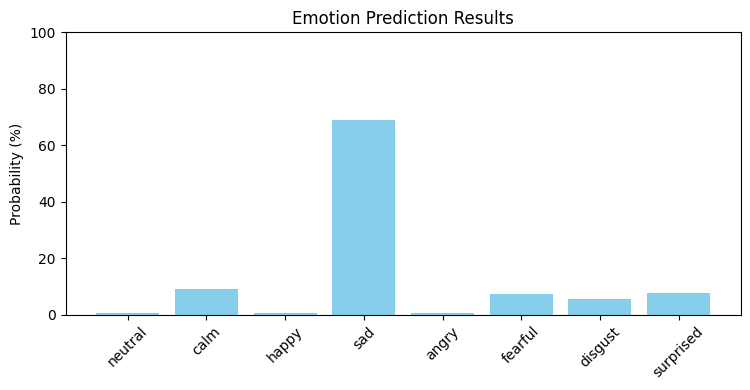

In [24]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import tkinter as tk
from tkinter import ttk, filedialog, messagebox
import threading
import time

# Important: Use tensorflow.keras for consistency if your model was saved with TF backend.
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential # Import both Model (for Functional API) and Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional, BatchNormalization, Conv1D, MaxPooling1D, Attention # All necessary layers
from tensorflow.keras import regularizers

import librosa

# Imports for Wav2Vec2
from transformers import AutoFeatureExtractor, Wav2Vec2Model
import torch

# --- Global Paths and Parameters ---
BASE_PATH = r"C:\Users\chenz\Documents" # Your base directory
H5_FILE_PATH = os.path.join(BASE_PATH, 'emotion_features.h5') # Used to get input shape if not hardcoded
LABELS_MAPPING_PATH = os.path.join(BASE_PATH, 'labels_mapping.npy')

# Paths to your trained model weights
CNN_LSTM_WEIGHTS_PATH = os.path.join(BASE_PATH, 'best_weights.weights.h5')
LSTM_ATTENTION_WEIGHTS_PATH = os.path.join(BASE_PATH, 'lstm_attention_best_weights.weights.h5')

emotions = {
    0 : 'neutral',
    1 : 'calm',
    2 : 'happy',
    3 : 'sad',
    4 : 'angry',
    5 : 'fearful',
    6 : 'disgust',
    7 : 'surprised'
}
EMO_LIST = list(emotions.values())

# --- Model Parameters (CRITICAL: Must match training) ---
# These should be derived from your H5_FILE_PATH, but hardcoding for simplicity here
# based on your previous scripts.
MODEL_INPUT_TIMESTEPS = 716
MODEL_INPUT_FEATURES = 768
NUM_OUTPUT_CLASSES = len(emotions)

# --- Wav2Vec2 Global Objects ---
WAV2VEC2_MODEL_NAME = "facebook/wav2vec2-base-960h"
FEATURE_EXTRACTOR = None
WAV2VEC2_MODEL = None
WAV2VEC2_TARGET_SR = 16000 # Wav2Vec2 expects 16kHz audio

# --- Global Flag for Critical Error ---
CRITICAL_ERROR_OCCURRED = False

# --- DummyModel for graceful failure ---
class DummyModel:
    def predict(self, x):
        probs = np.random.rand(1, len(emotions))
        probs = probs / np.sum(probs)
        return probs

# --- Wav2Vec2 Loading Function ---
def load_wav2vec2_components():
    global FEATURE_EXTRACTOR, WAV2VEC2_MODEL, CRITICAL_ERROR_OCCURRED
    try:
        print(f"Loading Wav2Vec2 feature extractor and model: {WAV2VEC2_MODEL_NAME}...")
        FEATURE_EXTRACTOR = AutoFeatureExtractor.from_pretrained(WAV2VEC2_MODEL_NAME)
        WAV2VEC2_MODEL = Wav2Vec2Model.from_pretrained(WAV2VEC2_MODEL_NAME)
        WAV2VEC2_MODEL.eval() # Set model to evaluation mode
        print("Wav2Vec2 model and feature extractor loaded successfully!")
    except Exception as e:
        print(f"CRITICAL ERROR: Could not load Wav2Vec2 components: {e}")
        print("Please ensure 'transformers' and 'torch' are installed and the model name is correct.")
        CRITICAL_ERROR_OCCURRED = True
        FEATURE_EXTRACTOR = None
        WAV2VEC2_MODEL = None

# --- Audio Preprocessing Function (Wav2Vec2) ---
def preprocess_audio_for_model(file_path, original_sr=None):
    global FEATURE_EXTRACTOR, WAV2VEC2_MODEL
    if FEATURE_EXTRACTOR is None or WAV2VEC2_MODEL is None:
        print("Wav2Vec2 model not loaded. Cannot preprocess. Returning zeros.")
        return np.zeros((1, MODEL_INPUT_TIMESTEPS, MODEL_INPUT_FEATURES), dtype=np.float32)

    try:
        # If original_sr is not provided, librosa will infer it.
        # It's safer to load with the original sample rate first, then resample if needed.
        y, sr = librosa.load(file_path, sr=None, mono=True)
        print(f"DEBUG: Loaded audio from '{os.path.basename(file_path)}' with original sample rate {sr}. Shape: {y.shape}")

        if sr != WAV2VEC2_TARGET_SR:
            print(f"Resampling audio from {sr} Hz to {WAV2VEC2_TARGET_SR} Hz for Wav2Vec2 processing.")
            y = librosa.resample(y=y, orig_sr=sr, target_sr=WAV2VEC2_TARGET_SR)
            sr = WAV2VEC2_TARGET_SR
            print(f"DEBUG: Resampled audio shape: {y.shape}")

        inputs = FEATURE_EXTRACTOR(y, sampling_rate=sr, return_tensors="pt")

        with torch.no_grad():
            outputs = WAV2VEC2_MODEL(**inputs)
            features = outputs.last_hidden_state.squeeze(0).numpy()

        print(f"DEBUG: Extracted Wav2Vec2 features. Shape: {features.shape}")

        current_timesteps = features.shape[0]

        if current_timesteps > MODEL_INPUT_TIMESTEPS:
            final_features = features[:MODEL_INPUT_TIMESTEPS, :]
            print(f"DEBUG: Truncated features from {current_timesteps} to {MODEL_INPUT_TIMESTEPS} timesteps.")
        elif current_timesteps < MODEL_INPUT_TIMESTEPS:
            pad_width = MODEL_INPUT_TIMESTEPS - current_timesteps
            final_features = np.pad(features, ((0, pad_width), (0, 0)), mode='constant', constant_values=0)
            print(f"DEBUG: Padded features from {current_timesteps} to {MODEL_INPUT_TIMESTEPS} timesteps with {pad_width} zeros.")
        else:
            final_features = features

        final_input_shape = np.expand_dims(final_features, axis=0)
        print(f"DEBUG: Final preprocessed input shape for Keras model: {final_input_shape.shape}")

        return final_input_shape

    except Exception as e:
        print(f"CRITICAL ERROR in Wav2Vec2 preprocess_audio_for_model function: {e}")
        import traceback
        traceback.print_exc()
        return np.zeros((1, MODEL_INPUT_TIMESTEPS, MODEL_INPUT_FEATURES), dtype=np.float32)


# --- Model Architecture Builder Functions (MUST MATCH TRAINING) ---

def build_cnn_lstm_model(input_timesteps, input_features, num_output_classes):
    """Reconstructs the CNN-LSTM model architecture."""
    model = Sequential(name='CNN-LSTM_Model')
    model.add(Conv1D(filters=128, kernel_size=5, activation='relu', kernel_regularizer=regularizers.l2(0.001),
                     input_shape=(input_timesteps, input_features)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.3))

    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.3))

    model.add(Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=regularizers.l2(0.001))))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Bidirectional(LSTM(32, kernel_regularizer=regularizers.l2(0.001))))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(num_output_classes, activation='softmax', kernel_regularizer=regularizers.l2(0.005)))
    return model

def build_lstm_attention_model(input_timesteps, input_features, num_output_classes):
    """Reconstructs the LSTM with Attention model architecture."""
    input_tensor = Input(shape=(input_timesteps, input_features), name='input_features')

    x = Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=regularizers.l2(0.005)), name='bi_lstm_1')(input_tensor)
    x = BatchNormalization(name='batch_norm_1')(x)
    x = Dropout(0.5, name='dropout_1')(x)

    attention_output = Attention(name='self_attention_layer')([x, x])

    x = Bidirectional(LSTM(32, kernel_regularizer=regularizers.l2(0.005)), name='bi_lstm_2')(attention_output)
    x = BatchNormalization(name='batch_norm_2')(x)
    x = Dropout(0.6, name='dropout_2')(x)

    output_tensor = Dense(num_output_classes, activation='softmax', kernel_regularizer=regularizers.l2(0.01), name='output_dense')(x)

    model = Model(inputs=input_tensor, outputs=output_tensor, name='LSTM_Attention_Model')
    return model


# --- Main Application Class ---
class AudioPredictionApp:
    def __init__(self, master):
        self.master = master
        master.title("Audio Emotion Predictor")
        master.geometry("800x750") # Increased height to accommodate probabilities text
        master.resizable(False, False)

        self.selected_file_path = tk.StringVar()
        self.selected_model = tk.StringVar(value="CNN-LSTM") # Default model selection

        self.model = None # Will hold the loaded Keras model

        self.create_widgets()
        self.load_initial_model() # Load default model on startup

        if CRITICAL_ERROR_OCCURRED:
            messagebox.showerror("Fatal Setup Error", "Wav2Vec2 components failed to load. Please check your internet connection and library installations. The application cannot function without them.")
            self.predict_button.config(state=tk.DISABLED)


    def create_widgets(self):
        # --- File Selection Frame ---
        file_frame = ttk.LabelFrame(self.master, text="1. Select Audio File", padding="10")
        file_frame.pack(pady=10, padx=10, fill=tk.X)

        ttk.Label(file_frame, text="Audio File:").pack(side=tk.LEFT, padx=5)
        self.file_entry = ttk.Entry(file_frame, textvariable=self.selected_file_path, width=50, state='readonly')
        self.file_entry.pack(side=tk.LEFT, padx=5, expand=True, fill=tk.X)
        ttk.Button(file_frame, text="Browse", command=self.browse_file).pack(side=tk.LEFT, padx=5)

        # --- Model Selection Frame ---
        model_frame = ttk.LabelFrame(self.master, text="2. Choose Model", padding="10")
        model_frame.pack(pady=10, padx=10, fill=tk.X)

        ttk.Radiobutton(model_frame, text="CNN-LSTM Model", variable=self.selected_model, value="CNN-LSTM",
                        command=self.load_selected_model).pack(side=tk.LEFT, padx=10)
        ttk.Radiobutton(model_frame, text="LSTM-Attention Model", variable=self.selected_model, value="LSTM-Attention",
                        command=self.load_selected_model).pack(side=tk.LEFT, padx=10)

        # --- Prediction Button Frame ---
        predict_frame = ttk.Frame(self.master, padding="10")
        predict_frame.pack(pady=10, padx=10, fill=tk.X)

        self.predict_button = ttk.Button(predict_frame, text="Predict Emotion", command=self.run_prediction_thread)
        self.predict_button.pack(pady=5)

        self.status_label = ttk.Label(predict_frame, text="Ready...", font=('Helvetica', 10, 'italic'))
        self.status_label.pack(pady=5)

        # --- Prediction Plot Frame ---
        plot_frame = ttk.LabelFrame(self.master, text="3. Prediction Results", padding="10")
        plot_frame.pack(pady=10, padx=10, fill=tk.BOTH, expand=True)

        self.fig, self.ax = plt.subplots(figsize=(8, 4))
        self.ax.set_ylim(0, 100)
        self.ax.set_ylabel("Probability (%)")
        self.ax.set_title("Emotion Prediction")
        self.bar_plot = self.ax.bar(EMO_LIST, np.zeros(len(EMO_LIST)), color='skyblue')
        self.ax.tick_params(axis='x', rotation=45) # Rotate x-axis labels for readability
        self.fig.tight_layout() # Adjust layout to prevent labels from overlapping

        self.canvas = FigureCanvasTkAgg(self.fig, master=plot_frame)
        self.canvas_widget = self.canvas.get_tk_widget()
        self.canvas_widget.pack(side=tk.TOP, fill=tk.BOTH, expand=True)

        # --- Probabilities Display Frame ---
        prob_frame = ttk.LabelFrame(self.master, text="4. Detailed Probabilities", padding="10")
        prob_frame.pack(pady=10, padx=10, fill=tk.X)

        self.prob_text = tk.Text(prob_frame, height=8, wrap="word", state='disabled', font=('Consolas', 10))
        self.prob_text.pack(pady=5, padx=5, fill=tk.X, expand=True)
        # Add a scrollbar to the text widget
        prob_scrollbar = ttk.Scrollbar(prob_frame, command=self.prob_text.yview)
        prob_scrollbar.pack(side=tk.RIGHT, fill=tk.Y)
        self.prob_text.config(yscrollcommand=prob_scrollbar.set)


    def browse_file(self):
        file_path = filedialog.askopenfilename(
            title="Select Audio File",
            filetypes=[("WAV files", "*.wav"), ("All files", "*.*")]
        )
        if file_path:
            self.selected_file_path.set(file_path)
            self.status_label.config(text=f"Selected: {os.path.basename(file_path)}")
            self.update_plot(np.zeros(len(EMO_LIST)), "Emotion Prediction") # Clear plot
            self.update_probabilities_text("") # Clear probabilities text

    def load_initial_model(self):
        # This is called once at startup to load the default model
        self.load_selected_model()

    def load_selected_model(self):
        model_type = self.selected_model.get()
        self.status_label.config(text=f"Loading {model_type} model...")
        self.predict_button.config(state=tk.DISABLED) # Disable button while loading
        self.update_probabilities_text("") # Clear probabilities text

        def _load():
            global CRITICAL_ERROR_OCCURRED
            if CRITICAL_ERROR_OCCURRED:
                self.master.after(0, self.status_label.config, {'text': "Fatal error, cannot load model.", 'foreground': 'red'})
                self.master.after(0, self.predict_button.config, {'state': tk.DISABLED})
                return

            try:
                if model_type == "CNN-LSTM":
                    self.model = build_cnn_lstm_model(MODEL_INPUT_TIMESTEPS, MODEL_INPUT_FEATURES, NUM_OUTPUT_CLASSES)
                    weights_path = CNN_LSTM_WEIGHTS_PATH
                elif model_type == "LSTM-Attention":
                    self.model = build_lstm_attention_model(MODEL_INPUT_TIMESTEPS, MODEL_INPUT_FEATURES, NUM_OUTPUT_CLASSES)
                    weights_path = LSTM_ATTENTION_WEIGHTS_PATH
                else:
                    raise ValueError("Unknown model type selected.")

                self.model.load_weights(weights_path)
                self.model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
                self.master.after(0, self.status_label.config, {'text': f"{model_type} model loaded successfully.", 'foreground': 'green'})
                self.master.after(0, self.predict_button.config, {'state': tk.NORMAL})
                print(f"INFO: {model_type} model loaded from {weights_path}")
            except FileNotFoundError:
                self.master.after(0, self.status_label.config, {'text': f"ERROR: Weights not found for {model_type}. Check path.", 'foreground': 'red'})
                self.master.after(0, self.predict_button.config, {'state': tk.DISABLED})
                print(f"ERROR: Weights not found for {model_type} at {weights_path}")
                self.model = DummyModel() # Fallback to dummy model
            except Exception as e:
                self.master.after(0, self.status_label.config, {'text': f"ERROR loading {model_type} model: {e}", 'foreground': 'red'})
                self.master.after(0, self.predict_button.config, {'state': tk.DISABLED})
                print(f"ERROR loading {model_type} model: {e}")
                import traceback
                traceback.print_exc()
                self.model = DummyModel() # Fallback to dummy model

        # Run loading in a separate thread to keep GUI responsive
        threading.Thread(target=_load).start()

    def run_prediction_thread(self):
        file_path = self.selected_file_path.get()
        if not file_path or not os.path.exists(file_path):
            messagebox.showwarning("No File Selected", "Please select an audio file first.")
            return
        if self.model is None or isinstance(self.model, DummyModel):
            messagebox.showerror("Model Not Loaded", "The model is not loaded correctly or is a dummy model. Cannot predict.")
            return
        if CRITICAL_ERROR_OCCURRED:
            messagebox.showerror("Fatal Error", "Wav2Vec2 components are not loaded. Cannot preprocess audio.")
            return

        self.predict_button.config(state=tk.DISABLED)
        self.status_label.config(text="Processing audio and predicting...")
        self.update_plot(np.zeros(len(EMO_LIST)), "Predicting...") # Clear plot
        self.update_probabilities_text("Calculating probabilities...") # Clear and update probabilities text

        threading.Thread(target=self._perform_prediction, args=(file_path,)).start()

    def _perform_prediction(self, file_path):
        try:
            # Preprocess the audio file
            x_processed = preprocess_audio_for_model(file_path)

            expected_shape = (1, MODEL_INPUT_TIMESTEPS, MODEL_INPUT_FEATURES)
            if x_processed.shape != expected_shape:
                self.master.after(0, self.status_label.config, {'text': f"ERROR: Preprocessing returned unexpected shape {x_processed.shape}. Expected {expected_shape}. Cannot predict.", 'foreground': 'red'})
                self.master.after(0, self.predict_button.config, {'state': tk.NORMAL})
                self.master.after(0, self.update_probabilities_text, "Preprocessing failed: Shape mismatch.")
                return

            # Make prediction
            predictions = self.model.predict(x_processed)
            pred_np = np.squeeze(predictions, axis=0)

            # Update GUI with results
            self.master.after(0, self.update_plot, pred_np, "Emotion Prediction Results")
            max_emo_index = np.argmax(pred_np)
            predicted_emotion = EMO_LIST[max_emo_index]
            self.master.after(0, self.status_label.config, {'text': f"Prediction Complete: {predicted_emotion}", 'foreground': 'blue'})

            # Format probabilities for display
            prob_display_text = ""
            for i, prob in enumerate(pred_np):
                prob_display_text += f"{EMO_LIST[i]:<10}: {prob*100:.2f}%\n"
            prob_display_text += f"\nMost likely: {predicted_emotion}"
            self.master.after(0, self.update_probabilities_text, prob_display_text)


            # Print probabilities to console (already existing)
            print(f"\n--- Prediction for {os.path.basename(file_path)} using {self.selected_model.get()} ---")
            for i, prob in enumerate(pred_np):
                print(f"  {EMO_LIST[i]:<10}: {prob*100:.2f}%")
            print(f"Most likely emotion: {predicted_emotion}")
            print("--------------------------------------------------")

        except Exception as e:
            self.master.after(0, messagebox.showerror, "Prediction Error", f"An error occurred during prediction: {e}")
            self.master.after(0, self.status_label.config, {'text': "Prediction failed.", 'foreground': 'red'})
            self.master.after(0, self.update_probabilities_text, f"Prediction failed: {e}")
            print(f"ERROR during prediction: {e}")
            import traceback
            traceback.print_exc()
        finally:
            self.master.after(0, self.predict_button.config, {'state': tk.NORMAL})

    def update_plot(self, pred_np, title):
        for i, bar in enumerate(self.bar_plot):
            bar.set_height(pred_np[i] * 100)
        self.ax.set_title(title)http://localhost:8889/notebooks/SER.ipynb#
        self.canvas.draw_idle()

    def update_probabilities_text(self, text):
        self.prob_text.config(state='normal') # Enable editing
        self.prob_text.delete(1.0, tk.END) # Clear existing text
        self.prob_text.insert(tk.END, text) # Insert new text
        self.prob_text.config(state='disabled') # Disable editing


if __name__ == "__main__":
    # Load Wav2Vec2 components once at the start
    load_wav2vec2_components()

    root = tk.Tk()
    app = AudioPredictionApp(root)
    root.mainloop()
